## Setup
Similar to the previous projects, we will need some code to set up the environment.

First, run this cell that loads the autoreload extension. This allows us to edit .py source files and re-import them into the notebook for a seamless editing and debugging experience.


In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Run the following cell to mount your Google Drive. Follow the link and sign in to your Google account (the same account you used to store this notebook!).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then enter your path of the project (for example, /content/drive/MyDrive/ConditionalDDPM)

In [6]:
%cd /content/drive/MyDrive/Lab 2 - DDPM

/content/drive/.shortcut-targets-by-id/1m9EirA_twVuGTTKciJ0L2YriS20P4kJv/Lab 2 - DDPM


We will use GPUs to accelerate our computation in this notebook. Go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab. **Rerun the top cell to mount your Drive again.** Run the following to make sure GPUs are enabled:

In [15]:
# set the device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via the downward triangle in the top right corner.')

Good to go!


## Conditional Denoising Diffusion Probabilistic Models

In the lectures, we have learnt about Denoising Diffusion Probabilistic Models (DDPM), as presented in the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf). We went through both the training process and test sampling process of DDPM. In this project, you will use conditional DDPM to generate digits based on given conditions. The project is inspired by the paper [Classifier-free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf), which is a following work of DDPM. You are required to use MNIST dataset and the GPU device to complete the project.

(It will take about 20\~30 minutes (10 epochs) if you are using the free-version Google Colab GPU. Typically, realistic digits can be generated after around 2\~5 epochs.)

### What is a DDPM?

A Denoising Diffusion Probabilistic Model (DDPM) is a type of generative model inspired by the natural diffusion process. In the example of image generation, DDPM works in two main stages:

- Forward Process (Diffusion): It starts with an image sampled from the dataset and gradually adds noise to it step by step, until it becomes completely random noise. In implementation, the forward diffusion process is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule $\beta_1, ..., \beta_T$.

- Reverse Process (Denoising): By learning how the noise was added on the image step by step, the model can do the reverse process: start with random noise and step by step, remove this noise to generate an image.

### Training and sampling of DDPM

As proposed in the DDPM paper, the training and sampling process can be concluded in the following steps:

<img src="https://drive.google.com/uc?export=view&id=1N5vswnDJDkM8QZ3ai8V7bfPi_fci3rwQ" width="800" height="200">

Here we still use the example of image generation.

Algorithm 1 shows the training process of DDPM. Initially, an image $\textbf{x}_0$ is sampled from the data distribution $q(\textbf{x}_0)$, i.e. the dataset. Then a time step $t$ is randomly selected from a uniform distribution across the predifined number of steps $T$.  
A noise $\epsilon$ which has the same shape of the image is sampled from a standard normal distribution.
According to the equation (4) in the DDPM paper and the new notation: $q(\textbf{x}_t|\textbf{x}_0) = \mathcal{N}(\textbf{x}_t; \sqrt{\bar{\alpha_t}}\textbf{x}_0, (1 - \bar{\alpha_t})\mathbf{I})$, $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t := \prod_{s=1}^{t} \alpha_s$, we can get an intermediate state of the diffusion process: $\textbf{x}_t = \sqrt{\bar{\alpha_t}}\textbf{x}_0 + \sqrt{(1 - \bar{\alpha_t})}\boldsymbol{\epsilon}$.
The model takes the $\textbf{x}_t$ and $t$ as inputs, and predict a noise, i.e. $\epsilon_{\theta}(\sqrt{\bar{\alpha_t}}\textbf{x}_0 + \sqrt{(1 - \bar{\alpha_t})}\boldsymbol{\epsilon}, t)$.
The optimization of the model is done by minimize the difference between the sampled noise and the model's prediction of noise.

Algorithm 2 shows the sampling process of DDPM, which is the complete procedure for generating an image. This process starts from noise $x_T$ sampled from a standard normal distribution, and then uses the trained model to iteratively apply denoising for each time step from $T$ to 1.

### How to control the generation output?

As you may find, the vanilla DDPM can only randomly generate images which are sampled from the learned distribution of the dataset, while in some cases, we are more interested in controlling the content of generated images.
Previous works mainly use an extra trained classifier to guide the diffusion model to generate specific images ([Dhariwal & Nichol (2021)](https://arxiv.org/pdf/2105.05233.pdf)).
Ho et al. proposed the [Classifier-free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf), which proposes a novel training and sampling method to achieve the conditional generation without extra models besides the diffusion model.
Now let's see how it modify the training and sampling pipeline of DDPM.

##### Algorithm 1: Conditional training
The training process is shown in the picture below. Some notations are modified in order to follow DDPM.

<img src="https://drive.google.com/uc?export=view&id=134deA1V2M5KkmZlnNeX-x6REMyscmHXo" alt="ConDDPM_1" width="800" height="240"/>

Compared with the training process of vanilla DDPM, there are several modifications.

- In the training data sampling, besides the image $\textbf{x}_0$, we also sample the condition $\textbf{c}_0$ from the dataset (usually the class label).

- There's a probabilistic step to randomly discard the conditions, training the model to generate data both conditionally and unconditionally. Usually we just set the one-hot encoded label as all -1 to discard the conditions.

- When optimizing the model, the condition $\textbf{c}_0$ is an extra input.

##### Algorithm 2: Conditional sampling

Below is the sampling process of conditional DDPM.

<img src="https://drive.google.com/uc?export=view&id=1wL_CbuyG2jckpXb8oPjO-BLOEJZxNyk0" width="500" height="250">

<!-- ![ConDDPM_2](https://drive.google.com/uc?export=view&id=1wL_CbuyG2jckpXb8oPjO-BLOEJZxNyk0) -->

Compared with the vanilla DDPM, the key modification is in step 4.
Here the algorithm computes a corrected noise estimation, $\tilde{\boldsymbol{\epsilon}}_t$, balancing between the conditional prediction $\boldsymbol{\epsilon}_{\theta}(\textbf{x}_t, \textbf{c}, t)$ and the unconditional prediction $\boldsymbol{\epsilon}_{\theta}(\textbf{x}_t, t)$. The corrected noise $\tilde{\boldsymbol{\epsilon}}_t$ is then used to update $\textbf{x}_t$ in step 5.
**Here we follow the setting of DDPM paper and define $\sigma_t = \sqrt{\beta_t}$.**

### Conditional generation of digits

Now let's practice it! You will first asked to design a denoising network, and then complete the training and sampling process of this conditional DDPM.
In this project, by default, we resize all images to a dimension of $28 \times 28$ and utilize one-hot encoding for class labels.

First we define a configuration class `DMConfig`. This class contains all the settings of the model and experiment that may be useful later.

In [12]:
from dataclasses import dataclass, field
from typing import List, Tuple
@dataclass
class DMConfig:
    '''
    Define the model and experiment settings here
    '''
    input_dim: Tuple[int, int] = (28, 28) # input image size
    num_channels: int = 1                 # input image channels
    condition_mask_value: int = -1        # unconditional condition mask value
    num_classes: int = 10                 # number of classes in the dataset
    T: int = 400                          # diffusion and denoising steps
    beta_1: float = 1e-4                  # variance schedule
    beta_T: float = 2e-2
    mask_p: float = 0.1                   # unconditional condition drop ratio
    num_feat: int = 128                   # feature size of the UNet model
    omega: float = 2.0                    # conditional guidance weight

    batch_size: int = 256                 # training batch size
    epochs: int = 10                      # training epochs
    learning_rate: float = 1e-4           # training learning rate
    multi_lr_milestones: List[int] = field(default_factory=lambda: [20]) # learning rate decay milestone
    multi_lr_gamma: float = 0.1           # learning rate decay ratio

Then let's prepare and visualize the dataset:

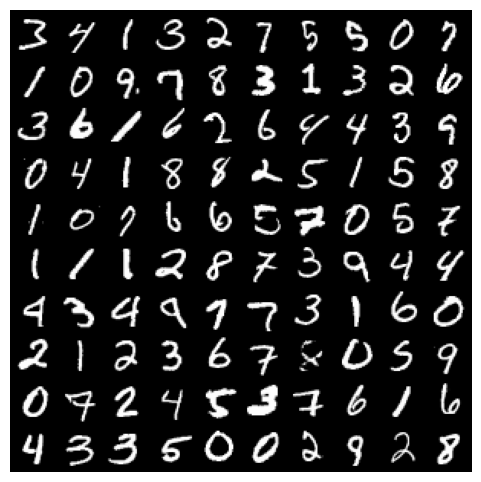

In [16]:
from utils import make_dataloader
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Define the data preprocessing and configuration
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
config = DMConfig()

# Create the train and test dataloaders
train_loader = make_dataloader(transform = transform, batch_size = config.batch_size, dir = './data', train = True)
test_loader = make_dataloader(transform = transform, batch_size = config.batch_size, dir = './data', train = False)

# Visualize the first 100 images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images_subset = images[:100]
grid = vutils.make_grid(images_subset, nrow = 10, normalize = True, padding=2)
plt.figure(figsize=(6, 6))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

#### 1. Denoising network (4 points)

The denoising network is defined in the file `ResUNet.py`. We have already provided some potentially useful blocks, and you will be asked to complete the class `ConditionalUnet`.

Some hints:

- **Please consider just using 2 down blocks and 2 up blocks. Using more blocks may improve the performance, while the training and sampling time may increase. Feel free to do some extra experiments in the creative exploring part later.**

- **An example structure of Conditional UNet is shown in the next cell. Here the initialization argument `n_feat` is set as 128. We provide all the potential useful components in the `__init__` function. The simplest way to construct the network is to complete the `forward` function with these components**


- **You can design your own network and add any blocks. Feel free to modifiy or even remove the provided blocks or layers. You are also free to change the way of adding the time step and condition.**



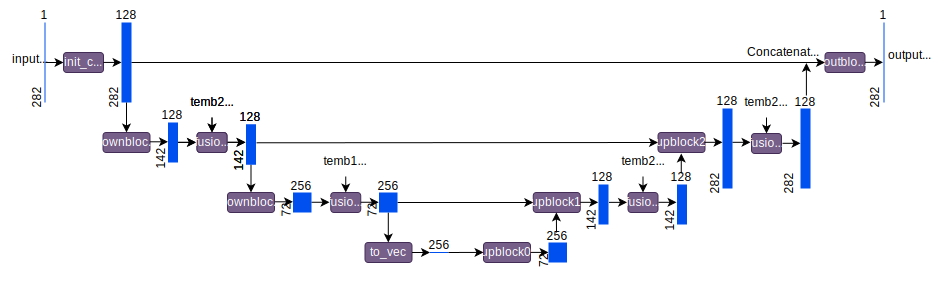

In [17]:
# Example structure of Conditional UNet
from IPython.core.display import SVG
SVG(filename='./pics/ConUNet.svg')

Now let's check your denoising network using the following code.

In [18]:
from ResUNet import ConditionalUnet
import torch

model = ConditionalUnet(in_channels = 1, n_feat = 128, n_classes = 10).to(device)
x = torch.randn((256,1,28,28)).to(device)
t = torch.randn((256,1,1,1)).to(device)
c = torch.randn((256,10)).to(device)
x_out = model(x,t,c)
assert x_out.shape == (256,1,28,28)
print('Output shape:', model(x,t,c).shape)
print('Dimension test passed!')

Output shape: torch.Size([256, 1, 28, 28])
Dimension test passed!


**Before proceeding, please remember to normalize the time step $t$ to the range 0-1 before inputting it into the denoising network for the next part of the project. It will help the network have a more stable output.**

#### 2. Conditional DDPM

With the correct denoising network, we can then start to build the pipeline of a conditional DDPM.
You will be asked to complete the `ConditionalDDPM` class in the file `DDPM.py`.

##### 2.1 Variance schedule (3 points)

Let's first prepare the variance schedule $\beta_t$ along with other potentially useful constants.
You are required to complete the `ConditionalDDPM.scheduler` function in `DDPM.py`.

Given the starting and ending variances $\beta_1$ and $\beta_T$, the function should output one dictionary containing the following terms:

`beta_t`: variance of time step $t_s$, which is linearly interpolated between $\beta_1$ and $\beta_T$.

`sqrt_beta_t`: $\sqrt{\beta_t}$

`alpha_t`: $\alpha_t = 1 - \beta_t$

`oneover_sqrt_alpha`: $\frac{1}{\sqrt{\alpha_t}}$

`alpha_t_bar`: $\bar{\alpha_t} = \prod_{s=1}^{t} \alpha_s$

`sqrt_alpha_bar`: $\sqrt{\bar{\alpha_t}}$

`sqrt_oneminus_alpha_bar`: $\sqrt{1 - \bar{\alpha_t}}$

We set $\beta_1 = 1e-4$ and $\beta_T = 2e-2$. Let's check your solution!

In [19]:
from DDPM import ConditionalDDPM
import torch
torch.set_printoptions(precision=8)
config = DMConfig(beta_1 = 1e-4, beta_T = 2e-2)
ConDDPM = ConditionalDDPM(dmconfig = config)
schedule_dict = ConDDPM.scheduler(t_s = torch.tensor(77)) # We use a specific time step (77) to check your output
assert torch.abs(schedule_dict['beta_t'] - 0.003890) <= 1e-5
assert torch.abs(schedule_dict['sqrt_beta_t'] - 0.062374) <= 1e-5
assert torch.abs(schedule_dict['alpha_t'] - 0.996110) <= 1e-5
assert torch.abs(schedule_dict['oneover_sqrt_alpha'] - 1.001951) <= 1e-5
assert torch.abs(schedule_dict['alpha_t_bar'] - 0.857414) <= 1e-5
assert torch.abs(schedule_dict['sqrt_oneminus_alpha_bar'] - 0.377606) <= 1e-5
print('All tests passed!')

All tests passed!


##### 2.2 Training process (5 points)

Recall the training algorithm we discussed above:

<img src="https://drive.google.com/uc?export=view&id=134deA1V2M5KkmZlnNeX-x6REMyscmHXo" alt="ConDDPM_1" width="800" height="240"/>

You will need to complete the  `ConditionalDDPM.forward` function in the `DDPM.py` file. Then you can use the function `utils.check_forward` to test if it's working properly. The model will be trained for one epoch in this checking process. It should take around 2 min and return one curve showing a decreasing loss trend if your `ConditionalDDPM.forward` function is correct.

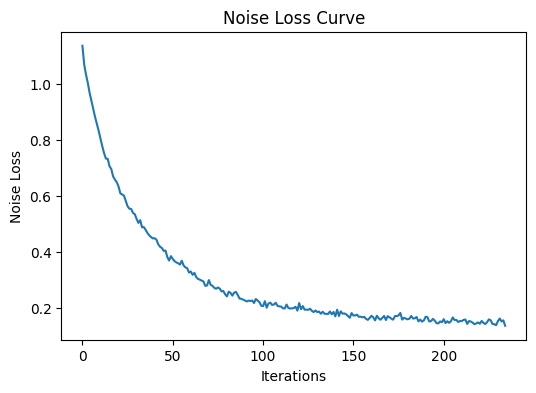

In [20]:
from utils import check_forward
config = DMConfig()
model = check_forward(train_loader, config, device)

2.3 Sampling process (5 points)

Now you are required to complete the `ConditionalDDPM.sample` function using the sampling process we mentioned above.

<img src="https://drive.google.com/uc?export=view&id=1wL_CbuyG2jckpXb8oPjO-BLOEJZxNyk0" width="500" height="250">

In the following cell, we will use the given `utils.check_sample` function to check the correctness. With the trained model in 2.2, the model should be able to generate some super-rough digits (you may not even see them as digits). The sampling process should take about 1 minute.

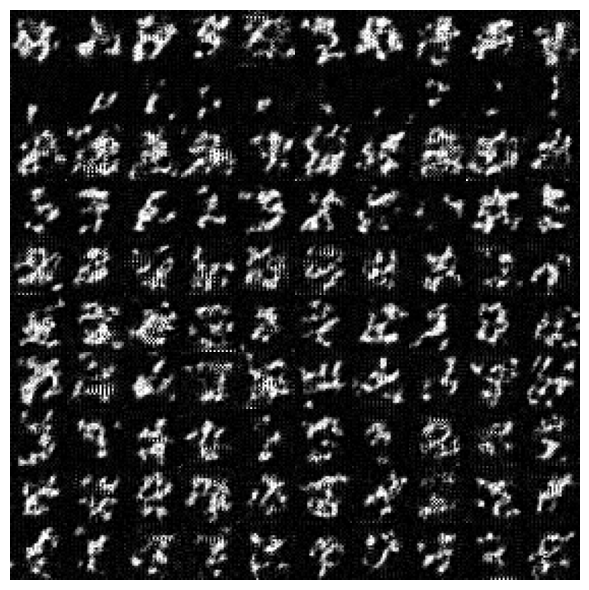

In [21]:
from utils import check_sample
config = DMConfig()
fig = check_sample(model, config, device)

##### 2.4 Full training (5 points)

As you might notice, the images generated are imperfect since the model trained for only one epoch has not yet converged. To improve the model's performance, we should proceed with a complete cycle of training and testing. You can utilize the provided `solver` function in this part.

Let's recall all model and experiment configurations:

In [36]:
train_config = DMConfig()
print(train_config)

DMConfig(input_dim=(28, 28), num_channels=1, condition_mask_value=-1, num_classes=10, T=400, beta_1=0.0001, beta_T=0.02, mask_p=0.1, num_feat=128, omega=2.0, batch_size=256, epochs=10, learning_rate=0.0001, multi_lr_milestones=[20], multi_lr_gamma=0.1)


Then we can use function `utils.solver` to train the model. You should also input your own experiment name, e.g. `your_exp_name`. The best-trained model will be saved as `./save/your_exp_name/best_checkpoint.pth`. Furthermore, for each training epoch, one generated image will be stored in the directory `./save/your_exp_name/images`.

In [37]:
from utils import solver
solver(dmconfig = train_config,
       exp_name = 'your_exp_name',
       train_loader = train_loader,
       test_loader = test_loader)

epoch 1/10


training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:41,  2.30it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:47,  2.17it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:49,  2.10it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:50,  2.08it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:51,  2.06it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:51,  2.04it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:52,  2.02it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:51,  2.02it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:04<01:52,  1.99it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:52,  2.00it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:05<01:51,  2.00it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:50,  2.00it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:06<01:50,  2.01it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:49,  2.01it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:07<01:49,  2.00it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:51,  1.96it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:08<01:51,  1.95it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:51,  1.95it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:09<01:51,  1.93it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:52,  1.91it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:10<01:52,  1.90it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:49,  1.93it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:11<01:47,  1.96it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:12<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:45,  1.97it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:44,  1.98it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:44,  1.98it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:14<01:42,  1.99it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:42,  2.00it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:15<01:41,  2.00it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:40,  2.01it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:16<01:40,  2.00it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:39,  2.01it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:17<01:39,  2.00it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:39,  2.00it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:39,  1.99it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:38,  1.99it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:37,  1.99it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:37,  1.99it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:36,  1.99it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:38,  1.95it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:38,  1.94it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:38,  1.93it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:39,  1.91it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:38,  1.90it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:39,  1.88it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:37,  1.91it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:36,  1.93it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:25<01:34,  1.95it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:33,  1.95it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:26<01:33,  1.96it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:32,  1.96it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:27<01:31,  1.96it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:30,  1.97it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:28<01:30,  1.97it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:29,  1.97it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:29<01:29,  1.97it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:28,  1.98it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:30<01:27,  1.98it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:27,  1.98it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:31<01:27,  1.98it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:26,  1.98it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:32<01:26,  1.97it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:33<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:24,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:34<01:25,  1.94it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:25,  1.92it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:35<01:25,  1.91it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:25,  1.91it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:25,  1.88it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:25,  1.88it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:23,  1.90it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:23,  1.91it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:21,  1.93it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:20,  1.94it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:20,  1.94it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:19,  1.95it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:19,  1.95it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:41<01:18,  1.95it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:17,  1.95it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:42<01:17,  1.95it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:16,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:43<01:16,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:15,  1.95it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:44<01:15,  1.96it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:14,  1.96it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:45<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:12,  1.97it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:46<01:12,  1.97it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:11,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:47<01:11,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:11,  1.96it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:48<01:11,  1.94it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:11,  1.93it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:49<01:11,  1.92it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:11,  1.89it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:50<01:11,  1.88it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:10,  1.91it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:51<01:09,  1.92it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:08,  1.94it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:52<01:07,  1.95it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:06,  1.96it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:53<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:54<01:04,  1.97it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:03,  1.97it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:55<01:03,  1.98it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:02,  1.98it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:56<01:02,  1.98it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:01,  1.98it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:57<01:00,  1.99it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:58<01:00,  1.99it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:58<00:59,  1.99it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [00:59<00:59,  1.99it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<00:58,  1.99it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:00<00:58,  1.98it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:58,  1.97it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:01<00:58,  1.94it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:58,  1.94it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:02<00:58,  1.91it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:57,  1.92it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:03<00:57,  1.91it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:57,  1.90it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:04<00:56,  1.92it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:55,  1.94it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:05<00:55,  1.92it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:54,  1.94it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:06<00:53,  1.95it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:52,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:07<00:52,  1.95it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:51,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:08<00:50,  1.96it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:50,  1.98it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:09<00:49,  1.97it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:49,  1.98it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:10<00:48,  1.96it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:48,  1.98it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:11<00:47,  1.97it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:46,  1.98it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:12<00:47,  1.95it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:13<00:46,  1.97it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:13<00:45,  1.96it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:14<00:46,  1.92it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:14<00:46,  1.91it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:15<00:45,  1.92it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:15<00:44,  1.91it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:16<00:44,  1.90it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:44,  1.88it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:17<00:43,  1.92it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:42,  1.92it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:18<00:41,  1.94it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:40,  1.96it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:19<00:40,  1.97it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.97it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:20<00:39,  1.97it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.98it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:21<00:37,  1.98it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:37,  1.98it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:22<00:36,  1.98it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:36,  1.97it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:23<00:35,  1.98it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:35,  1.97it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:24<00:34,  1.98it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:34,  1.98it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:25<00:33,  1.98it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:33,  1.98it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:26<00:32,  1.98it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:32,  1.98it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:27<00:32,  1.93it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:32,  1.93it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:28<00:31,  1.92it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:31,  1.92it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:29<00:30,  1.91it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:30<00:30,  1.89it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:30<00:29,  1.92it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:31<00:28,  1.93it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:31<00:28,  1.95it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:32<00:27,  1.96it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:32<00:27,  1.96it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:33<00:26,  1.97it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:33<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:34<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:34<00:24,  1.97it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:35<00:24,  1.97it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:35<00:23,  1.97it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:36<00:23,  1.97it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:36<00:22,  1.98it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:37<00:22,  1.97it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:37<00:21,  1.98it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:38<00:21,  1.98it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:38<00:20,  1.98it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:39<00:20,  1.98it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:39<00:19,  1.98it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:40<00:19,  1.97it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:40<00:18,  1.95it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:41<00:18,  1.90it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:18,  1.88it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:42<00:17,  1.89it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:17,  1.90it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:43<00:17,  1.88it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:16,  1.86it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:44<00:16,  1.84it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:15,  1.84it/s]

start of conditional unet forward
start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:46<00:14,  1.83it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:46<00:13,  1.88it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:47<00:13,  1.90it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:47<00:12,  1.93it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:48<00:11,  1.94it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:48<00:11,  1.95it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:49<00:10,  1.96it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:49<00:10,  1.97it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:50<00:09,  1.97it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:50<00:09,  1.97it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:51<00:08,  1.97it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:51<00:08,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:52<00:07,  1.97it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:52<00:07,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:53<00:06,  1.98it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.98it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:54<00:05,  1.98it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.98it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:55<00:04,  1.98it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.98it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:56<00:03,  1.95it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.94it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:57<00:02,  1.93it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.92it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:58<00:01,  1.89it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.89it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [01:59<00:00,  1.92it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:12,  3.21it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:11,  3.35it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:10,  3.44it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:10,  3.49it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:09,  3.51it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:09,  3.49it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:09,  3.46it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:09,  3.47it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:09,  3.43it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:02<00:08,  3.46it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:08,  3.49it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:08,  3.49it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:03<00:07,  3.50it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:07,  3.49it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:07,  3.47it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:04<00:07,  3.41it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:04<00:06,  3.45it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:06,  3.47it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:05<00:06,  3.49it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:05<00:05,  3.41it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:05,  3.39it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:06<00:05,  3.41it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:06<00:05,  3.37it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:06<00:04,  3.42it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:07<00:04,  3.45it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:07<00:04,  3.47it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:07<00:03,  3.45it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:08<00:03,  3.45it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:08<00:03,  3.46it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:08<00:02,  3.44it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:08<00:02,  3.45it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:09<00:02,  3.47it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:09<00:02,  3.23it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:09<00:01,  3.14it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:10<00:01,  3.09it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:10<00:01,  3.06it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:10<00:00,  3.01it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:11<00:00,  2.99it/s]

start of conditional unet forward


test:  98%|█████████▊| 39/40 [00:11<00:00,  3.05it/s]

start of conditional unet forward
start of conditional unet forward


train: train_noise_loss = 0.2958 test: test_noise_loss = 0.1465
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condition

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:43,  2.26it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:49,  2.11it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:52,  2.05it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:53,  2.02it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:54,  2.00it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:53,  2.00it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:54,  1.98it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:55,  1.96it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:04<01:55,  1.94it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:55,  1.93it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:05<01:55,  1.94it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:56,  1.91it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:07<01:57,  1.89it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:54,  1.91it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:53,  1.94it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:52,  1.95it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:51,  1.95it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:49,  1.96it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:49,  1.96it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:47,  1.97it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:47,  1.97it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:47,  1.97it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:45,  1.98it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:44,  1.97it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:44,  1.98it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:43,  1.97it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:43,  1.97it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:42,  1.97it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:42,  1.97it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:43,  1.94it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:43,  1.93it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:42,  1.94it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:42,  1.93it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:42,  1.93it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:42,  1.92it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:43,  1.89it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:41,  1.91it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:39,  1.94it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:38,  1.94it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:37,  1.95it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:36,  1.96it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:36,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:35,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:34,  1.97it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:34,  1.98it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:33,  1.98it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:25<01:33,  1.97it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:32,  1.97it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:26<01:31,  1.98it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:31,  1.98it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:27<01:30,  1.98it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:30,  1.98it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:28<01:30,  1.97it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:29,  1.98it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:29<01:29,  1.98it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:30,  1.94it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:29,  1.94it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:29,  1.93it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:29,  1.92it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:29,  1.91it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:29,  1.91it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:29,  1.90it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:27,  1.93it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:25,  1.94it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:25,  1.95it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.97it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:23,  1.97it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:22,  1.97it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:22,  1.98it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:21,  1.97it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:20,  1.98it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:20,  1.97it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:19,  1.98it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:19,  1.98it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:18,  1.98it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:18,  1.97it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:17,  1.98it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:41<01:17,  1.97it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:16,  1.98it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:42<01:16,  1.97it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:15,  1.98it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:43<01:16,  1.94it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:16,  1.93it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:44<01:16,  1.93it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:15,  1.92it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:45<01:15,  1.92it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:15,  1.90it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:46<01:14,  1.93it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:12,  1.95it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:47<01:12,  1.96it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:11,  1.97it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:48<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:10,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:49<01:09,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:08,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:50<01:08,  1.98it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:07,  1.98it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:07,  1.98it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:06,  1.98it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:06,  1.97it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:05,  1.97it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:04,  1.98it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:03,  1.98it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:03,  1.98it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:02,  1.98it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:03,  1.95it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:03,  1.93it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:02,  1.93it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:58<01:02,  1.91it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:02,  1.90it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [00:59<01:02,  1.89it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<01:00,  1.92it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:00<01:00,  1.93it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:58,  1.95it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:01<00:58,  1.95it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.96it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:02<00:57,  1.96it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:03<00:56,  1.96it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:55,  1.96it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:04<00:55,  1.95it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:54,  1.96it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:05<00:54,  1.95it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:53,  1.96it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:06<00:53,  1.95it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:52,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:07<00:52,  1.95it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:51,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:08<00:50,  1.97it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:50,  1.98it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:09<00:49,  1.97it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:49,  1.95it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:10<00:49,  1.92it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:49,  1.92it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:48,  1.92it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:48,  1.90it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:49,  1.88it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:13<00:47,  1.91it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:46,  1.92it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:14<00:45,  1.94it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:45,  1.95it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:15<00:44,  1.96it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:43,  1.97it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:16<00:43,  1.97it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:42,  1.97it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:17<00:42,  1.97it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:41,  1.97it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:18<00:41,  1.97it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:40,  1.97it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:19<00:39,  1.98it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.98it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:20<00:38,  1.99it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.99it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:21<00:37,  1.98it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:37,  1.98it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:22<00:36,  1.98it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:36,  1.97it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:23<00:36,  1.95it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:36,  1.94it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:24<00:35,  1.93it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:35,  1.93it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:25<00:35,  1.91it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:34,  1.90it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:26<00:33,  1.92it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:33,  1.93it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:27<00:32,  1.95it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:28<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:30,  1.97it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:29<00:29,  1.97it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:30<00:29,  1.97it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:30<00:28,  1.97it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:31<00:28,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:31<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:32<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:32<00:26,  1.97it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:33<00:26,  1.98it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:33<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:34<00:25,  1.98it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:34<00:24,  1.98it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:35<00:24,  1.97it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:23,  1.98it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:36<00:23,  1.95it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.94it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:37<00:22,  1.94it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:22,  1.93it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:38<00:21,  1.92it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:21,  1.90it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:39<00:20,  1.93it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:20,  1.94it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:40<00:19,  1.91it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:41<00:19,  1.92it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:41<00:18,  1.92it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:18,  1.93it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:42<00:17,  1.92it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:17,  1.92it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:43<00:16,  1.93it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:15,  1.95it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:44<00:15,  1.95it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:14,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:45<00:14,  1.98it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:46<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:46<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:47<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:47<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:48<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:48<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:49<00:10,  1.97it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:49<00:10,  1.95it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:50<00:09,  1.94it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:50<00:09,  1.92it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:51<00:08,  1.93it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.91it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:52<00:07,  1.89it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.93it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:53<00:06,  1.95it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.96it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:54<00:05,  1.97it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:55<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:56<00:03,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.98it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:57<00:02,  1.98it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.97it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:58<00:01,  1.98it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.98it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [01:59<00:00,  1.98it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:12,  3.17it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:11,  3.28it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.30it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:10,  3.36it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:10,  3.35it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.39it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:09,  3.42it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:09,  3.41it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:09,  3.43it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:09,  3.24it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:09,  3.15it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:09,  3.07it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:04<00:08,  3.09it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:08,  3.06it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:08,  3.02it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:05<00:07,  3.01it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:08,  2.87it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:07,  2.86it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:06<00:07,  2.89it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  3.01it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:06,  3.15it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:06<00:05,  3.22it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  3.28it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:07<00:04,  3.35it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:07<00:04,  3.35it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  3.38it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:08<00:03,  3.39it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:08<00:03,  3.44it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:08<00:03,  3.45it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:09<00:02,  3.44it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:09<00:02,  3.45it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:09<00:02,  3.42it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.38it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:10<00:01,  3.37it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:10<00:01,  3.40it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  3.41it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:11<00:00,  3.43it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:11<00:00,  3.44it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward
train: train_noise_loss = 0.1270 test: test_noise_loss = 0.1125


start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condi

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:43,  2.24it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:49,  2.12it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:52,  2.05it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:53,  2.03it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:53,  2.01it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:53,  2.00it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:54,  1.99it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:53,  1.99it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:04<01:53,  1.98it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:52,  1.98it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:05<01:52,  1.98it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:51,  1.98it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:06<01:51,  1.98it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:50,  1.98it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:07<01:50,  1.98it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:50,  1.98it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:08<01:49,  1.98it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:51,  1.94it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:51,  1.94it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:51,  1.92it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:50,  1.92it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:50,  1.91it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:50,  1.91it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:51,  1.88it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:48,  1.92it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:46,  1.95it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:45,  1.96it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:45,  1.96it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:43,  1.97it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:44,  1.95it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:43,  1.97it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:42,  1.97it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:41,  1.98it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:41,  1.96it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:41,  1.97it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:41,  1.96it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:40,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:40,  1.96it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:38,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:39,  1.96it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:37,  1.97it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:36,  1.98it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:36,  1.98it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:39,  1.91it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:38,  1.92it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:38,  1.91it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:38,  1.91it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:37,  1.90it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:37,  1.89it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:26<01:38,  1.86it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:36,  1.90it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:34,  1.93it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:33,  1.94it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:32,  1.94it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:31,  1.96it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:30,  1.96it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:30,  1.96it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:29,  1.97it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:28,  1.97it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:28,  1.97it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:26,  1.98it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:26,  1.98it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:24,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:23,  1.98it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.98it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:24,  1.93it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:24,  1.93it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:24,  1.93it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:23,  1.93it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:23,  1.91it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:23,  1.90it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:21,  1.94it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:20,  1.95it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:19,  1.96it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:18,  1.96it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:18,  1.97it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:41<01:17,  1.97it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:16,  1.97it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:42<01:16,  1.98it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:15,  1.98it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:43<01:15,  1.97it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:14,  1.98it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:44<01:14,  1.98it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:13,  1.98it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:45<01:13,  1.98it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:12,  1.97it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:46<01:12,  1.98it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:11,  1.98it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:47<01:11,  1.98it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:10,  1.98it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:48<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:11,  1.94it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:49<01:10,  1.94it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:10,  1.93it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:10,  1.92it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:10,  1.89it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:10,  1.89it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:08,  1.93it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:07,  1.94it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:06,  1.95it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:06,  1.95it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:05,  1.96it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:04,  1.97it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:03,  1.97it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:03,  1.97it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:02,  1.97it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:02,  1.97it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:01,  1.98it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:01,  1.98it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:58<01:00,  1.98it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:00,  1.98it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [00:59<00:59,  1.98it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<00:59,  1.98it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:00<00:58,  1.98it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:58,  1.98it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:01<00:57,  1.98it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.98it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:02<00:57,  1.94it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:57,  1.93it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:03<00:56,  1.94it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:56,  1.93it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:04<00:56,  1.92it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:55,  1.91it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:05<00:54,  1.94it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:53,  1.95it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:06<00:53,  1.96it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:52,  1.97it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:07<00:51,  1.97it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:51,  1.97it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:08<00:50,  1.97it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:50,  1.98it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:09<00:49,  1.98it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:49,  1.98it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:10<00:48,  1.98it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:48,  1.98it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:11<00:47,  1.98it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:47,  1.98it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:12<00:46,  1.98it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:13<00:46,  1.98it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:13<00:45,  1.98it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:14<00:45,  1.97it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:14<00:44,  1.98it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:15<00:44,  1.97it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:15<00:44,  1.94it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:16<00:44,  1.93it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:43,  1.93it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:17<00:43,  1.92it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:43,  1.90it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:18<00:42,  1.90it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:41,  1.94it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:19<00:40,  1.95it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.96it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:20<00:39,  1.96it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.97it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:21<00:38,  1.96it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:37,  1.97it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:22<00:37,  1.97it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:36,  1.98it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:23<00:36,  1.97it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:35,  1.98it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:24<00:35,  1.96it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:34,  1.96it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:25<00:34,  1.96it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:33,  1.97it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:26<00:33,  1.96it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:32,  1.97it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:27<00:32,  1.95it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:28<00:31,  1.95it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:30,  1.94it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:29<00:30,  1.92it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:30<00:30,  1.91it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:30<00:29,  1.90it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:31<00:29,  1.89it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:31<00:29,  1.87it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:32<00:28,  1.91it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:27,  1.93it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:33<00:26,  1.95it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:26,  1.93it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:34<00:25,  1.94it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:25,  1.95it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:35<00:24,  1.97it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:24,  1.96it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:36<00:23,  1.93it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.92it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:37<00:22,  1.92it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:22,  1.91it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:38<00:22,  1.89it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:21,  1.87it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:39<00:20,  1.91it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:20,  1.93it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:40<00:19,  1.94it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:41<00:18,  1.95it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:41<00:18,  1.96it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:18,  1.90it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:42<00:17,  1.90it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:17,  1.91it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:43<00:16,  1.91it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:16,  1.90it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:44<00:15,  1.89it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:15,  1.92it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:45<00:14,  1.94it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:46<00:13,  1.95it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:46<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:47<00:12,  1.96it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:48<00:11,  1.97it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:49<00:10,  1.97it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.98it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:50<00:09,  1.96it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.98it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:51<00:08,  1.97it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:52<00:07,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:53<00:06,  1.98it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.98it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:54<00:05,  1.98it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.97it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:55<00:04,  1.95it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.94it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:56<00:03,  1.93it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.93it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:57<00:02,  1.92it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.91it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:58<00:01,  1.95it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.95it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [01:59<00:00,  1.96it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:12,  3.17it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:11,  3.29it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.36it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:10,  3.38it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:10,  3.40it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.37it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:09,  3.41it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:09,  3.40it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:09,  3.41it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:02<00:08,  3.42it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:08,  3.42it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:08,  3.41it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:03<00:08,  3.36it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:07,  3.39it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:07,  3.43it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:04<00:07,  3.41it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:06,  3.39it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:06,  3.40it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:05<00:06,  3.43it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:05<00:05,  3.39it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:05,  3.42it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:06<00:05,  3.41it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:06<00:04,  3.41it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:07<00:04,  3.41it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:07<00:04,  3.41it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:07<00:04,  3.41it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:07<00:03,  3.37it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:08<00:03,  3.37it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:08<00:03,  3.39it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:08<00:03,  3.21it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:09<00:02,  3.13it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:09<00:02,  3.14it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:09<00:02,  3.14it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:10<00:01,  3.09it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:10<00:01,  3.08it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:10<00:01,  3.03it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:11<00:01,  2.95it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:11<00:00,  2.88it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward
train: train_noise_loss = 0.1058 test: test_noise_loss = 0.0973


start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condi

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:45,  2.22it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:50,  2.10it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:52,  2.05it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:55,  2.00it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:57,  1.96it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:57,  1.94it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:57,  1.93it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:58,  1.91it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:05<01:57,  1.92it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:58,  1.89it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:06<01:58,  1.89it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:55,  1.92it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:07<01:54,  1.94it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:52,  1.95it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:52,  1.95it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:50,  1.96it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:50,  1.97it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:47,  1.97it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:47,  1.98it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:46,  1.98it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:46,  1.98it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:45,  1.98it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:44,  1.98it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:44,  1.98it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:43,  1.97it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:43,  1.97it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:43,  1.96it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:44,  1.94it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:44,  1.93it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:44,  1.92it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:43,  1.91it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:44,  1.89it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:45,  1.87it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:42,  1.90it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:41,  1.92it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:40,  1.94it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:39,  1.95it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:38,  1.96it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:37,  1.96it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:23<01:36,  1.96it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:35,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:24<01:35,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:34,  1.98it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:25<01:34,  1.98it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:33,  1.97it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:26<01:33,  1.98it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:32,  1.98it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:32,  1.98it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:31,  1.98it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:31,  1.97it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:30,  1.98it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:29,  1.98it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:31,  1.92it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:31,  1.92it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:31,  1.91it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:31,  1.91it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:31,  1.90it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:30,  1.89it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:30,  1.88it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:28,  1.91it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:27,  1.92it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:26,  1.95it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:25,  1.95it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:24,  1.96it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.97it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:23,  1.96it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:22,  1.97it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:22,  1.97it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:21,  1.97it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:21,  1.97it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:20,  1.98it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:19,  1.98it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:19,  1.97it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:19,  1.97it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:18,  1.96it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:18,  1.96it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:41<01:18,  1.95it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:17,  1.96it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:42<01:18,  1.92it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:18,  1.91it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:44<01:18,  1.91it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:17,  1.91it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:45<01:17,  1.90it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:17,  1.90it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:46<01:17,  1.87it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:16,  1.89it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:47<01:14,  1.92it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:13,  1.94it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:48<01:12,  1.95it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:11,  1.96it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:11,  1.96it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:10,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:09,  1.96it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:09,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:08,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:08,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:08,  1.95it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:07,  1.97it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:06,  1.96it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:05,  1.98it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:04,  1.98it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:04,  1.98it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:03,  1.98it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:04,  1.92it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:04,  1.92it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:04,  1.91it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:03,  1.91it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:03,  1.90it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:59<01:03,  1.90it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:03,  1.87it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [01:00<01:02,  1.90it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<01:01,  1.91it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:01<00:59,  1.94it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:59,  1.94it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:02<00:58,  1.96it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.96it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:56,  1.96it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:04<00:56,  1.96it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:55,  1.96it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:05<00:54,  1.97it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:54,  1.96it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:06<00:53,  1.98it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:53,  1.98it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:07<00:52,  1.97it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:52,  1.98it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:51,  1.97it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:51,  1.98it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:09<00:50,  1.98it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:51,  1.92it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:50,  1.92it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:50,  1.91it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:50,  1.91it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:50,  1.89it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:49,  1.88it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:49,  1.87it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:48,  1.91it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:13<00:47,  1.91it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:46,  1.93it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:14<00:46,  1.93it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:45,  1.95it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:16<00:44,  1.95it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:43,  1.96it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:17<00:43,  1.97it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:42,  1.97it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:18<00:41,  1.98it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:41,  1.97it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:19<00:40,  1.98it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:40,  1.98it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:20<00:39,  1.98it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.98it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:21<00:38,  1.98it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.98it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:22<00:37,  1.98it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:37,  1.98it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:23<00:37,  1.94it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:37,  1.94it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:24<00:36,  1.93it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:36,  1.92it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:25<00:36,  1.91it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:35,  1.91it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:26<00:34,  1.94it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:33,  1.95it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:27<00:33,  1.95it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:32,  1.97it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:28<00:32,  1.96it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:31,  1.97it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:29<00:30,  1.97it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:30,  1.97it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:30<00:29,  1.97it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:30<00:29,  1.98it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:31<00:28,  1.98it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:31<00:28,  1.98it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:32<00:27,  1.98it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:32<00:27,  1.98it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:26,  1.98it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:33<00:26,  1.98it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:34<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:25,  1.94it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:35<00:24,  1.94it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:24,  1.91it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:36<00:24,  1.90it/s]

start of conditional unet forward
start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:38<00:23,  1.90it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:22,  1.89it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:39<00:22,  1.88it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:21,  1.87it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:40<00:21,  1.86it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:21,  1.85it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:41<00:20,  1.87it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:41<00:19,  1.91it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:42<00:18,  1.93it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:18,  1.94it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:43<00:17,  1.96it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:16,  1.96it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:44<00:16,  1.97it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:15,  1.97it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:45<00:15,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:14,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:46<00:14,  1.97it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:46<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:47<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.98it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:48<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:49<00:10,  1.98it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.98it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:50<00:09,  1.97it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.98it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:51<00:08,  1.95it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.93it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:52<00:07,  1.93it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.92it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:54<00:06,  1.89it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.89it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:55<00:05,  1.93it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.94it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:56<00:04,  1.95it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.96it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:57<00:03,  1.96it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.97it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:58<00:02,  1.97it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.97it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:59<00:01,  1.97it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.97it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [02:00<00:00,  1.98it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:12,  3.15it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:11,  3.28it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.34it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:10,  3.33it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:10,  3.35it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.35it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:09,  3.34it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:09,  3.34it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:09,  3.34it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:02<00:08,  3.36it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:08,  3.34it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:08,  3.33it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:03<00:08,  3.34it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:07,  3.33it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:07,  3.17it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:04<00:07,  3.11it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:07,  3.03it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:07,  3.04it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:05<00:07,  2.97it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  2.94it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:06,  2.97it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:06<00:06,  2.91it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  2.87it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:07<00:05,  2.83it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:07<00:05,  2.95it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  2.98it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:08<00:04,  3.09it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:08<00:03,  3.18it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:09<00:03,  3.21it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:09<00:03,  3.24it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:09<00:02,  3.27it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:10<00:02,  3.30it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.30it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:10<00:01,  3.34it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:10<00:01,  3.35it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  3.33it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:11<00:00,  3.37it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:11<00:00,  3.35it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward
train: train_noise_loss = 0.0947 test: test_noise_loss = 0.0897


start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condi

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:51,  2.09it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:52,  2.05it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:54,  2.02it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:54,  2.01it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:54,  2.00it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:54,  1.99it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:54,  1.99it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:53,  1.99it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:04<01:53,  1.98it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:53,  1.97it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:05<01:52,  1.98it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:52,  1.97it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:06<01:51,  1.98it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:51,  1.97it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:50,  1.98it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:50,  1.97it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:49,  1.98it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:48,  1.98it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:47,  1.98it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:48,  1.95it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:48,  1.94it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:49,  1.92it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:48,  1.92it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:49,  1.89it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:49,  1.89it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:48,  1.90it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:46,  1.93it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:45,  1.93it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:44,  1.95it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:43,  1.94it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:43,  1.95it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:42,  1.95it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:41,  1.96it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:40,  1.96it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:38,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:37,  1.98it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:37,  1.97it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:37,  1.98it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:36,  1.98it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:35,  1.98it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:35,  1.98it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:35,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:34,  1.97it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:35,  1.94it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:35,  1.94it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:25<01:35,  1.93it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:35,  1.92it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:35,  1.91it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:35,  1.90it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:35,  1.89it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:33,  1.92it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:32,  1.93it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:30,  1.95it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:30,  1.95it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:29,  1.96it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:28,  1.97it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:26,  1.97it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:26,  1.97it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:24,  1.98it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:24,  1.97it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.97it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:23,  1.98it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:22,  1.98it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:22,  1.97it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:21,  1.98it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:22,  1.95it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:22,  1.93it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:22,  1.93it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:21,  1.92it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:21,  1.92it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:21,  1.90it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:21,  1.88it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:41<01:19,  1.92it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:18,  1.93it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:42<01:17,  1.94it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:16,  1.95it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:43<01:16,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:15,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:44<01:15,  1.96it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:14,  1.97it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:45<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:46<01:12,  1.97it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:12,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:47<01:11,  1.98it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:09,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:09,  1.98it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:08,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:08,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:09,  1.94it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:08,  1.94it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:08,  1.93it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:08,  1.92it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:07,  1.92it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:07,  1.91it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:07,  1.90it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:05,  1.93it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:04,  1.94it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:04,  1.95it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:03,  1.96it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:02,  1.96it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:01,  1.97it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:01,  1.97it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:58<01:00,  1.97it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:00,  1.98it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [00:59<00:59,  1.98it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<00:59,  1.97it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:00<00:58,  1.97it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:58,  1.98it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:01<00:57,  1.97it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.98it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:02<00:56,  1.98it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:56,  1.98it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:03<00:55,  1.98it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:55,  1.97it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:04<00:54,  1.98it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:54,  1.95it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:05<00:54,  1.93it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:54,  1.92it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:06<00:54,  1.92it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:54,  1.90it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:54,  1.89it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:52,  1.92it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:09<00:51,  1.94it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:50,  1.95it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:50,  1.96it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:49,  1.96it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:48,  1.97it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:48,  1.97it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:47,  1.97it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:47,  1.98it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:46,  1.97it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:13<00:45,  1.98it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:45,  1.98it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:14<00:44,  1.98it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:44,  1.97it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:15<00:43,  1.98it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:43,  1.98it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:16<00:42,  1.98it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:42,  1.98it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:17<00:41,  1.98it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:41,  1.97it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:18<00:41,  1.95it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:41,  1.94it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:19<00:41,  1.93it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:40,  1.92it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:20<00:40,  1.91it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:40,  1.89it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:21<00:38,  1.93it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:38,  1.95it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:22<00:37,  1.96it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:36,  1.96it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:23<00:36,  1.97it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:35,  1.96it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:24<00:34,  1.97it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:34,  1.97it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:25<00:33,  1.98it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:33,  1.97it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:26<00:32,  1.98it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:32,  1.97it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:27<00:31,  1.98it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:31,  1.98it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:28<00:30,  1.98it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:30,  1.97it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:29<00:30,  1.93it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:30<00:30,  1.92it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:30<00:29,  1.91it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:31<00:29,  1.91it/s]

start of conditional unet forward
start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:32<00:29,  1.85it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:28,  1.85it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:33<00:28,  1.84it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:27,  1.84it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:34<00:26,  1.87it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:26,  1.86it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:35<00:25,  1.86it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:24,  1.89it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:36<00:24,  1.91it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.93it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:37<00:22,  1.95it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:21,  1.96it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:38<00:21,  1.96it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:20,  1.96it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:39<00:20,  1.97it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:19,  1.97it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:40<00:19,  1.97it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:41<00:18,  1.98it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:41<00:18,  1.97it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:17,  1.97it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:42<00:17,  1.98it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:16,  1.97it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:43<00:16,  1.98it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:15,  1.96it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:44<00:15,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:14,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:45<00:14,  1.94it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:46<00:14,  1.92it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.91it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:47<00:13,  1.88it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.90it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:48<00:12,  1.87it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.86it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:49<00:11,  1.89it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.91it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:50<00:09,  1.93it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.95it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:51<00:08,  1.96it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.96it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:52<00:07,  1.96it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.97it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:53<00:06,  1.97it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.97it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:54<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:55<00:04,  1.96it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.96it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:56<00:03,  1.96it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.96it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:57<00:02,  1.95it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.95it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:58<00:01,  1.95it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.96it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [01:59<00:00,  1.92it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:13,  2.85it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:13,  2.80it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:01<00:12,  2.87it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:12,  2.92it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:12,  2.83it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:02<00:12,  2.76it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:12,  2.68it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:11,  2.83it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:03<00:10,  2.96it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:09,  3.06it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:09,  3.11it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:04<00:08,  3.17it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:04<00:08,  3.22it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:07,  3.27it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:07,  3.30it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:05<00:07,  3.32it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:06,  3.31it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:06,  3.29it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:06<00:06,  3.26it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  3.27it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:05,  3.30it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:07<00:05,  3.29it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  3.28it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:07<00:04,  3.30it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:07<00:04,  3.30it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  3.33it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:08<00:03,  3.34it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:08<00:03,  3.30it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:09<00:03,  3.33it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:09<00:03,  3.33it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:09<00:02,  3.33it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:10<00:02,  3.33it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.32it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:10<00:01,  3.33it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:10<00:01,  3.30it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  3.32it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:11<00:00,  3.33it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:11<00:00,  3.34it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward
train: train_noise_loss = 0.0871

 test: test_noise_loss = 0.0831
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditi

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:42,  2.27it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:49,  2.13it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:51,  2.08it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:52,  2.04it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:52,  2.03it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:52,  2.02it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:53,  2.01it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:53,  2.00it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:04<01:54,  1.97it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:53,  1.97it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:05<01:53,  1.97it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:52,  1.97it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:06<01:53,  1.94it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:53,  1.93it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:07<01:53,  1.93it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:53,  1.92it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:53,  1.91it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:53,  1.91it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:54,  1.88it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:51,  1.92it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:50,  1.93it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:48,  1.95it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:47,  1.96it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:47,  1.96it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:45,  1.97it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:45,  1.97it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:44,  1.98it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:43,  1.98it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:43,  1.98it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:42,  1.98it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:42,  1.98it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:41,  1.98it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:41,  1.98it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:40,  1.98it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:40,  1.98it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:39,  1.98it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:40,  1.93it/s]

start of conditional unet forward
start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:40,  1.92it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:40,  1.91it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:40,  1.91it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:40,  1.89it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:41,  1.87it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:38,  1.90it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:37,  1.92it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:35,  1.94it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:35,  1.95it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:25<01:33,  1.96it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:33,  1.96it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:32,  1.97it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:31,  1.97it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:31,  1.96it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:30,  1.98it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:29,  1.98it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:29,  1.97it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:29,  1.98it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:28,  1.98it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:28,  1.97it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:27,  1.98it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:26,  1.97it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:25,  1.98it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.98it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:26,  1.95it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:26,  1.94it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:26,  1.92it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:25,  1.92it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:26,  1.89it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:26,  1.88it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:24,  1.91it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:23,  1.92it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:22,  1.94it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:21,  1.95it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:20,  1.96it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:19,  1.97it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:19,  1.97it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:18,  1.97it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:18,  1.97it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:41<01:17,  1.97it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:16,  1.98it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:42<01:16,  1.98it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:16,  1.97it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:43<01:15,  1.97it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:14,  1.98it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:44<01:14,  1.97it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:13,  1.98it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:45<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:12,  1.98it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:46<01:12,  1.98it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:13,  1.94it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:47<01:12,  1.94it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:12,  1.93it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:12,  1.92it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:12,  1.90it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:12,  1.90it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:12,  1.89it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:10,  1.92it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:09,  1.93it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:08,  1.94it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:07,  1.95it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:06,  1.96it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:06,  1.96it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:04,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:04,  1.96it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:03,  1.97it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:03,  1.97it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:02,  1.97it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:02,  1.98it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:01,  1.97it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:01,  1.97it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:58<01:00,  1.98it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:00,  1.96it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [00:59<00:59,  1.97it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<00:59,  1.96it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:00<00:59,  1.94it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:59,  1.92it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:01<00:59,  1.92it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:59,  1.91it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:02<00:58,  1.92it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:58,  1.90it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:03<00:58,  1.88it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:57,  1.91it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:04<00:55,  1.93it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:55,  1.94it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:05<00:54,  1.95it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:53,  1.96it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:06<00:52,  1.97it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:52,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:51,  1.97it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:51,  1.97it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:09<00:50,  1.98it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:50,  1.96it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:49,  1.96it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:49,  1.95it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:48,  1.97it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:48,  1.96it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:47,  1.97it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:47,  1.97it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:46,  1.98it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:13<00:46,  1.98it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:46,  1.93it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:14<00:46,  1.90it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:46,  1.91it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:15<00:45,  1.90it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:45,  1.90it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:16<00:45,  1.88it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:45,  1.87it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:17<00:43,  1.89it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:42,  1.92it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:18<00:41,  1.94it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:41,  1.95it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:19<00:40,  1.95it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.97it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:20<00:39,  1.96it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.97it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:21<00:38,  1.95it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:37,  1.96it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:22<00:37,  1.96it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:36,  1.96it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:23<00:36,  1.97it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:35,  1.97it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:24<00:35,  1.96it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:34,  1.95it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:26<00:35,  1.91it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:34,  1.91it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:27<00:34,  1.89it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:33,  1.89it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:28<00:33,  1.87it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:32,  1.89it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:29<00:32,  1.87it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:32,  1.87it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:30<00:31,  1.85it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:30<00:31,  1.86it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:31<00:30,  1.85it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:31<00:30,  1.85it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:32<00:28,  1.90it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:32<00:28,  1.92it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:27,  1.93it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:33<00:26,  1.94it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:26,  1.95it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:34<00:25,  1.96it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:25,  1.96it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:36<00:24,  1.97it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:24,  1.95it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:37<00:23,  1.96it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.96it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:38<00:22,  1.97it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:21,  1.97it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:39<00:21,  1.98it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:20,  1.96it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:40<00:20,  1.97it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:19,  1.97it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:41<00:19,  1.98it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:41<00:18,  1.98it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:42<00:18,  1.98it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:17,  1.95it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:43<00:17,  1.94it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:17,  1.93it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:44<00:16,  1.92it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:16,  1.89it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:45<00:15,  1.89it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:15,  1.92it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:46<00:14,  1.94it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:46<00:13,  1.95it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.96it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:47<00:12,  1.96it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:48<00:11,  1.97it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:49<00:10,  1.98it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.98it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:50<00:09,  1.98it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.98it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:51<00:08,  1.98it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:52<00:07,  1.98it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.97it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:53<00:06,  1.97it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.98it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:54<00:05,  1.98it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.98it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:55<00:04,  1.94it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.93it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:56<00:03,  1.92it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.91it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:58<00:02,  1.91it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.89it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:59<00:01,  1.93it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.95it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [02:00<00:00,  1.96it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:12,  3.10it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:11,  3.21it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.28it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:10,  3.31it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:10,  3.30it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.27it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:09,  3.30it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:09,  3.32it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:09,  3.31it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:09,  3.32it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:08,  3.33it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:08,  3.32it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:03<00:08,  3.31it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:07,  3.34it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:07,  3.31it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:04<00:07,  3.28it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:06,  3.30it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:06,  3.30it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:05<00:06,  3.30it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  3.29it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:05,  3.30it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:06<00:05,  3.30it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:06<00:05,  3.24it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:07<00:04,  3.28it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:07<00:04,  3.29it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:07<00:04,  3.25it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:08<00:03,  3.29it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:08<00:03,  3.31it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:08<00:03,  3.15it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:09<00:03,  3.07it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:09<00:02,  3.08it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:09<00:02,  3.07it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.00it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:10<00:02,  2.97it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:10<00:01,  3.00it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  2.92it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:11<00:01,  2.87it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:11<00:00,  2.77it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward


train: train_noise_loss = 0.0809 test: test_noise_loss = 0.0785
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condition

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:44,  2.23it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:49,  2.12it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:53,  2.03it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:54,  2.01it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:55,  1.98it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:54,  1.99it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:03<01:55,  1.97it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:57,  1.92it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:05<01:57,  1.91it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:57,  1.91it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:06<01:57,  1.90it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:57,  1.88it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:07<01:58,  1.87it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:58,  1.86it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:55,  1.89it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:53,  1.92it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:52,  1.94it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:51,  1.94it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:49,  1.96it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.96it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:48,  1.97it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:47,  1.96it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:47,  1.97it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:46,  1.96it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:45,  1.98it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:44,  1.97it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:44,  1.97it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:44,  1.97it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:43,  1.97it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:43,  1.96it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:43,  1.94it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:43,  1.95it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:43,  1.94it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:44,  1.91it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:44,  1.90it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:43,  1.90it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:20<01:43,  1.90it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:43,  1.88it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:21<01:42,  1.88it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:42,  1.88it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:22<01:40,  1.91it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:39,  1.92it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:23<01:38,  1.94it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:37,  1.94it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:24<01:36,  1.96it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:35,  1.96it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:25<01:35,  1.96it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:35,  1.95it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:26<01:34,  1.96it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:33,  1.96it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:32,  1.96it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:32,  1.96it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:31,  1.96it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:32,  1.94it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:31,  1.95it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:31,  1.94it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:30,  1.95it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:30,  1.94it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:29,  1.95it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:31,  1.90it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:30,  1.90it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:30,  1.89it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:30,  1.88it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:34<01:29,  1.89it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:29,  1.88it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:35<01:30,  1.85it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:27,  1.89it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:36<01:26,  1.92it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:24,  1.94it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:37<01:24,  1.94it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:23,  1.95it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:38<01:23,  1.94it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:22,  1.94it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:39<01:21,  1.95it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:20,  1.96it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:40<01:20,  1.95it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:19,  1.96it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:41<01:19,  1.95it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:18,  1.95it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:42<01:18,  1.95it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:17,  1.96it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:43<01:17,  1.95it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:16,  1.95it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:44<01:16,  1.94it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:15,  1.95it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:45<01:17,  1.91it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:16,  1.91it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:46<01:16,  1.90it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:16,  1.89it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:47<01:15,  1.89it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:48<01:16,  1.86it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:48<01:15,  1.86it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:49<01:13,  1.90it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:12,  1.92it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:50<01:11,  1.94it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:10,  1.95it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:51<01:09,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:08,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:52<01:08,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:07,  1.97it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:53<01:07,  1.97it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:06,  1.97it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:54<01:05,  1.98it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:05,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:55<01:04,  1.97it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:05,  1.95it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:56<01:04,  1.96it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:03,  1.96it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:57<01:03,  1.96it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:02,  1.96it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:58<01:01,  1.97it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:01,  1.95it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:59<01:02,  1.93it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:02,  1.90it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [01:00<01:02,  1.90it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<01:01,  1.89it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:01<01:01,  1.90it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<01:01,  1.87it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:02<01:01,  1.86it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:03<00:59,  1.90it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:03<00:58,  1.92it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:04<00:57,  1.94it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:04<00:56,  1.94it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:05<00:55,  1.95it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:05<00:55,  1.96it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:06<00:54,  1.96it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:06<00:53,  1.97it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:07<00:53,  1.96it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:07<00:52,  1.97it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:08<00:52,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:51,  1.98it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:09<00:51,  1.96it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:09<00:50,  1.96it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:10<00:50,  1.95it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:49,  1.96it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:11<00:49,  1.95it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:49,  1.95it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:12<00:48,  1.94it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:49,  1.92it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:13<00:49,  1.90it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:48,  1.90it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:14<00:48,  1.88it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:47,  1.88it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:15<00:47,  1.88it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:47,  1.87it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:16<00:45,  1.90it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:44,  1.92it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:17<00:44,  1.92it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:43,  1.94it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:18<00:42,  1.94it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:19<00:42,  1.95it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:19<00:41,  1.95it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:20<00:41,  1.95it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:20<00:41,  1.91it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:21<00:40,  1.91it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:21<00:40,  1.91it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:22<00:39,  1.90it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:22<00:39,  1.90it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:23<00:39,  1.88it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:23<00:39,  1.86it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:24<00:37,  1.90it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:24<00:36,  1.92it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:25<00:36,  1.94it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:25<00:35,  1.96it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:26<00:35,  1.93it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:26<00:34,  1.92it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:27<00:34,  1.92it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:27<00:33,  1.91it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:28<00:33,  1.91it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:28<00:33,  1.89it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:29<00:33,  1.87it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:30<00:32,  1.90it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:30<00:31,  1.92it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:31<00:30,  1.94it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:31<00:29,  1.95it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:32<00:29,  1.96it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:32<00:28,  1.96it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:33<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:33<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:34<00:26,  1.97it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:34<00:26,  1.98it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:35<00:25,  1.98it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:35<00:25,  1.98it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:36<00:24,  1.98it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:36<00:24,  1.98it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:37<00:23,  1.98it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:37<00:23,  1.98it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:38<00:22,  1.97it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:38<00:22,  1.97it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:39<00:21,  1.96it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:39<00:21,  1.93it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:40<00:21,  1.92it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:40<00:20,  1.92it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:41<00:20,  1.90it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:41<00:19,  1.91it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:42<00:19,  1.89it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:42<00:19,  1.87it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:43<00:18,  1.91it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:43<00:17,  1.92it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:44<00:16,  1.94it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:44<00:16,  1.95it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:45<00:15,  1.96it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:45<00:15,  1.96it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:46<00:14,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:46<00:14,  1.97it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:47<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:48<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:49<00:11,  1.97it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:50<00:10,  1.97it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.98it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:51<00:09,  1.96it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.97it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:52<00:08,  1.97it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:53<00:08,  1.96it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:53<00:07,  1.93it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:54<00:07,  1.91it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:54<00:06,  1.90it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:55<00:06,  1.90it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:55<00:05,  1.89it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:56<00:05,  1.89it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:56<00:04,  1.86it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:57<00:04,  1.90it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:57<00:03,  1.93it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:58<00:03,  1.95it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:58<00:02,  1.95it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:59<00:02,  1.96it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:59<00:01,  1.94it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [02:00<00:01,  1.96it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [02:00<00:00,  1.95it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:13,  2.91it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:12,  3.03it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.11it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:11,  3.17it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:10,  3.21it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.22it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:10,  3.20it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:09,  3.23it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:09,  3.25it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:09,  3.26it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:08,  3.23it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:08,  3.14it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:04<00:08,  3.15it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:08,  3.16it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:04<00:07,  3.13it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:05<00:07,  3.14it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:07,  3.15it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:05<00:07,  2.97it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:06<00:07,  2.94it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  2.96it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:06<00:06,  2.89it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:07<00:06,  2.91it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  2.88it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:07<00:05,  2.87it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:08<00:05,  2.86it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  2.81it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:08<00:04,  2.81it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:09<00:04,  2.76it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:09<00:03,  2.90it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:09<00:03,  2.97it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:10<00:03,  3.00it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:10<00:02,  3.06it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.11it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:11<00:01,  3.16it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:11<00:01,  3.19it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  3.19it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:12<00:00,  3.20it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:12<00:00,  3.22it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward


train: train_noise_loss = 0.0776 test: test_noise_loss = 0.0747
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condition

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:45,  2.21it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:52,  2.06it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:55,  2.00it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:56,  1.98it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:57,  1.95it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:59,  1.91it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:04<01:56,  1.94it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:55,  1.96it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:05<01:53,  1.97it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:53,  1.97it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:06<01:52,  1.98it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:52,  1.98it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:07<01:51,  1.98it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:51,  1.97it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:51,  1.97it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:50,  1.97it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:49,  1.97it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:49,  1.98it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:48,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:49,  1.95it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:48,  1.95it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:47,  1.96it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:46,  1.96it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:46,  1.97it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:45,  1.97it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:47,  1.93it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:47,  1.92it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:46,  1.92it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:46,  1.91it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:46,  1.90it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:46,  1.90it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:46,  1.89it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:44,  1.92it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:42,  1.93it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:41,  1.95it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:40,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:38,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:37,  1.98it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:37,  1.97it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:37,  1.98it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:36,  1.97it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:35,  1.98it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:35,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:35,  1.98it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:35,  1.96it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:34,  1.97it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:35,  1.95it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:25<01:34,  1.95it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:34,  1.94it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:33,  1.95it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:34,  1.91it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:34,  1.90it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:35,  1.88it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:34,  1.89it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:33,  1.89it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:33,  1.88it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:34,  1.86it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:31,  1.89it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:30,  1.92it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:28,  1.94it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:27,  1.95it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:26,  1.96it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:25,  1.96it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:24,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:24,  1.97it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.97it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:22,  1.98it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:23,  1.96it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:22,  1.96it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:22,  1.95it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:21,  1.95it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:21,  1.95it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:20,  1.96it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:19,  1.96it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:18,  1.98it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:20,  1.92it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:20,  1.92it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:42<01:19,  1.92it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:19,  1.91it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:43<01:19,  1.90it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:19,  1.89it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:44<01:19,  1.87it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:17,  1.90it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:45<01:16,  1.93it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:15,  1.94it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:46<01:14,  1.95it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:13,  1.96it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:47<01:12,  1.97it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:12,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:48<01:11,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:09,  1.98it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:10,  1.96it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:09,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:09,  1.95it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:08,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:08,  1.95it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:07,  1.96it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:07,  1.94it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:06,  1.96it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:06,  1.95it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:06,  1.93it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:06,  1.91it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:06,  1.91it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:06,  1.88it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:57<01:06,  1.88it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:06,  1.86it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:58<01:04,  1.90it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:03,  1.91it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:59<01:02,  1.93it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:01,  1.93it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [01:00<01:00,  1.95it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<01:00,  1.95it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:01<00:59,  1.95it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:59,  1.95it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:02<00:58,  1.96it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.96it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:04<00:55,  1.98it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:55,  1.97it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:05<00:55,  1.96it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:54,  1.95it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:06<00:54,  1.96it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:53,  1.97it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:07<00:52,  1.97it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:52,  1.98it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:52,  1.94it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:52,  1.93it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:09<00:52,  1.92it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:51,  1.92it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:51,  1.91it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:51,  1.89it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:51,  1.86it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:12<00:51,  1.85it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:50,  1.86it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:13<00:49,  1.86it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:49,  1.87it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:14<00:48,  1.86it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:48,  1.87it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:15<00:48,  1.85it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:46,  1.89it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:16<00:45,  1.92it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:44,  1.94it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:17<00:43,  1.94it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:42,  1.96it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:18<00:42,  1.95it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:41,  1.96it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:19<00:41,  1.96it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:40,  1.98it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:20<00:40,  1.97it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.98it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:21<00:39,  1.97it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.98it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:22<00:38,  1.93it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:38,  1.92it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:23<00:38,  1.89it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:37,  1.90it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:24<00:37,  1.89it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:25<00:37,  1.89it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:25<00:36,  1.87it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:26<00:35,  1.91it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:26<00:34,  1.93it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:27<00:34,  1.93it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:27<00:33,  1.94it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:28<00:32,  1.95it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:28<00:32,  1.95it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:29<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:29<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:30<00:30,  1.97it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:30<00:30,  1.97it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:31<00:29,  1.98it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:31<00:28,  1.97it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:32<00:28,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:32<00:28,  1.96it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:33<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:27,  1.96it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:34<00:26,  1.97it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:35<00:25,  1.98it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:25,  1.92it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:36<00:25,  1.92it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:24,  1.91it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:37<00:24,  1.91it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.91it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:38<00:23,  1.89it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:22,  1.87it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:39<00:22,  1.90it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:21,  1.92it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:40<00:20,  1.93it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:19,  1.95it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:41<00:19,  1.96it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:42<00:18,  1.97it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:42<00:18,  1.96it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:43<00:17,  1.97it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:43<00:17,  1.97it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:44<00:16,  1.98it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:44<00:16,  1.97it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:45<00:15,  1.98it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:45<00:15,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:46<00:14,  1.98it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:46<00:14,  1.98it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:47<00:13,  1.98it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.98it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:48<00:12,  1.98it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.98it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:49<00:11,  1.98it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.95it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:50<00:10,  1.94it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.93it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:51<00:09,  1.92it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.91it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:52<00:08,  1.89it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.87it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:53<00:07,  1.90it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.92it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:54<00:06,  1.93it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.95it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:55<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:56<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:57<00:03,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.97it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:58<00:02,  1.97it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.98it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:59<00:01,  1.98it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.98it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [02:00<00:00,  1.98it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:13,  2.95it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:12,  3.11it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.17it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:11,  3.19it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:10,  3.19it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.14it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:10,  3.13it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:10,  3.00it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:10,  2.96it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:10,  2.93it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:09,  2.92it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:03<00:09,  2.89it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:04<00:09,  2.93it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:09,  2.88it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:05<00:08,  2.79it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:05<00:08,  2.74it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:08,  2.69it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:06<00:07,  2.76it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:06<00:07,  2.90it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  2.99it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:07<00:06,  3.01it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:07<00:05,  3.09it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  3.12it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:08<00:05,  3.14it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:08<00:04,  3.14it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  3.12it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:09<00:04,  3.13it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:09<00:03,  3.12it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:09<00:03,  3.16it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:09<00:03,  3.17it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:10<00:02,  3.20it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:10<00:02,  3.20it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.21it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:11<00:01,  3.22it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:11<00:01,  3.18it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  3.17it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:12<00:00,  3.18it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:12<00:00,  3.16it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward
train: train_noise_loss = 0.0740

 test: test_noise_loss = 0.0714
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditi

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:54,  2.04it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:55,  2.01it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:55,  1.99it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:55,  1.99it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:55,  1.99it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:55,  1.98it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:04<01:54,  1.98it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:54,  1.98it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:05<01:53,  1.98it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:53,  1.98it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:06<01:52,  1.98it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:51,  1.99it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:07<01:51,  1.98it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:50,  1.99it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:50,  1.99it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:49,  1.98it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:49,  1.98it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.98it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:49,  1.94it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:49,  1.94it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:49,  1.92it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:49,  1.92it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:49,  1.91it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:50,  1.89it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:50,  1.87it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:48,  1.91it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:46,  1.92it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:45,  1.94it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:44,  1.95it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:43,  1.95it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:42,  1.96it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:41,  1.97it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:41,  1.97it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:40,  1.97it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:39,  1.96it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:38,  1.97it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:37,  1.97it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:37,  1.97it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:36,  1.97it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:36,  1.97it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:35,  1.97it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:35,  1.96it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:35,  1.96it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:24<01:36,  1.94it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:35,  1.93it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:26<01:35,  1.92it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:35,  1.92it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:35,  1.91it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:34,  1.91it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:35,  1.88it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:33,  1.92it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:32,  1.93it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:30,  1.95it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:29,  1.96it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:29,  1.96it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:28,  1.96it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:26,  1.98it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:26,  1.98it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.98it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:25,  1.97it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:24,  1.98it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:24,  1.97it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.97it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:23,  1.97it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:22,  1.98it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:22,  1.96it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:21,  1.97it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:23,  1.91it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:23,  1.91it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:23,  1.90it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:22,  1.89it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:22,  1.88it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:22,  1.88it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:22,  1.87it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:42<01:20,  1.90it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:19,  1.92it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:43<01:18,  1.94it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:16,  1.95it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:44<01:16,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:15,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:45<01:14,  1.97it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:14,  1.97it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:46<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:47<01:12,  1.98it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:12,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:48<01:11,  1.98it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:11,  1.97it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:10,  1.98it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:10,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:09,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:09,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:08,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:08,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:08,  1.95it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:08,  1.93it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:08,  1.92it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:08,  1.90it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:07,  1.90it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:07,  1.89it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:08,  1.87it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:06,  1.89it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:05,  1.90it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:56<01:04,  1.92it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:03,  1.94it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:57<01:02,  1.95it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:01,  1.96it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:58<01:01,  1.96it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:00,  1.97it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [00:59<00:59,  1.97it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<00:59,  1.97it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:01<00:59,  1.95it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:58,  1.96it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:02<00:58,  1.95it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.97it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:03<00:57,  1.96it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:04<00:56,  1.96it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:55,  1.96it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:05<00:55,  1.95it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:56,  1.89it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:06<00:56,  1.87it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:56,  1.86it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:07<00:55,  1.86it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:55,  1.86it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:54,  1.86it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:54,  1.85it/s]

start of conditional unet forward
start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:10<00:53,  1.84it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:53,  1.83it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:11<00:52,  1.83it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:53,  1.80it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:12<00:52,  1.81it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:50,  1.86it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:13<00:49,  1.89it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:48,  1.91it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:14<00:47,  1.93it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:46,  1.95it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:15<00:45,  1.95it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:44,  1.96it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:16<00:44,  1.97it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:43,  1.96it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:17<00:43,  1.97it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:42,  1.97it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:18<00:42,  1.97it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:41,  1.97it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:19<00:41,  1.97it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:40,  1.98it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:20<00:39,  1.99it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:39,  1.99it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:21<00:38,  1.98it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:38,  1.98it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:22<00:39,  1.91it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:38,  1.91it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:23<00:38,  1.91it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:37,  1.90it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:24<00:37,  1.90it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:25<00:37,  1.88it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:25<00:37,  1.86it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:26<00:35,  1.90it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:26<00:34,  1.92it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:27<00:34,  1.94it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:27<00:33,  1.95it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:28<00:32,  1.95it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:28<00:32,  1.96it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:29<00:31,  1.97it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:29<00:30,  1.97it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:30<00:30,  1.97it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:30<00:29,  1.98it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:31<00:29,  1.97it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:31<00:28,  1.97it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:32<00:28,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:32<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:33<00:27,  1.98it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:26,  1.98it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:34<00:26,  1.98it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:25,  1.98it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:35<00:25,  1.97it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:24,  1.98it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:36<00:24,  1.93it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:24,  1.93it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:37<00:24,  1.91it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.91it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:38<00:23,  1.89it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:23,  1.86it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:39<00:22,  1.85it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:40<00:21,  1.88it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:40<00:20,  1.91it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:41<00:20,  1.92it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:41<00:19,  1.94it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:42<00:18,  1.96it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:42<00:18,  1.96it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:43<00:17,  1.96it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:43<00:17,  1.97it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:44<00:16,  1.97it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:44<00:16,  1.97it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:45<00:15,  1.98it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:45<00:15,  1.97it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:46<00:14,  1.98it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:46<00:14,  1.96it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:47<00:13,  1.97it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.96it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:48<00:12,  1.97it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.96it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:49<00:11,  1.97it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.97it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:50<00:10,  1.95it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.94it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:51<00:09,  1.91it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.92it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:52<00:08,  1.90it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.88it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:53<00:07,  1.90it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.93it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:54<00:06,  1.94it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.96it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:55<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.97it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:56<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:57<00:03,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.97it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:58<00:02,  1.97it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.97it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:59<00:01,  1.97it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.98it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [02:00<00:00,  1.98it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:13,  2.85it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:12,  3.01it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:00<00:11,  3.10it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:11,  3.09it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:11,  3.11it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:01<00:10,  3.15it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:10,  3.15it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:10,  3.02it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:02<00:10,  2.90it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:10,  2.88it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:03<00:10,  2.87it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:04<00:09,  2.84it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:04<00:09,  2.85it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:04<00:09,  2.85it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:05<00:08,  2.90it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:05<00:08,  2.85it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:05<00:08,  2.81it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:06<00:08,  2.72it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:06<00:07,  2.77it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  2.90it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:07<00:06,  2.97it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:07<00:05,  3.03it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  3.06it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:08<00:05,  3.13it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:08<00:04,  3.16it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  3.16it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:09<00:04,  3.17it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:09<00:03,  3.16it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:09<00:03,  3.13it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:10<00:03,  3.16it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:10<00:02,  3.17it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:10<00:02,  3.10it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:10<00:02,  3.13it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:11<00:01,  3.14it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:11<00:01,  3.15it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:11<00:01,  3.17it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:12<00:00,  3.17it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:12<00:00,  3.18it/s]

start of conditional unet forward


start of conditional unet forward
start of conditional unet forward
train: train_noise_loss = 0.0720 test: test_noise_loss = 0.0685


start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condi

training:   0%|          | 0/235 [00:00<?, ?it/s]

start of conditional unet forward


training:   1%|          | 2/235 [00:00<01:56,  2.00it/s]

start of conditional unet forward


training:   1%|▏         | 3/235 [00:01<01:56,  2.00it/s]

start of conditional unet forward


training:   2%|▏         | 4/235 [00:01<01:55,  2.00it/s]

start of conditional unet forward


training:   2%|▏         | 5/235 [00:02<01:55,  1.99it/s]

start of conditional unet forward


training:   3%|▎         | 6/235 [00:02<01:55,  1.99it/s]

start of conditional unet forward


training:   3%|▎         | 7/235 [00:03<01:54,  1.98it/s]

start of conditional unet forward


training:   3%|▎         | 8/235 [00:04<01:54,  1.98it/s]

start of conditional unet forward


training:   4%|▍         | 9/235 [00:04<01:53,  1.98it/s]

start of conditional unet forward


training:   4%|▍         | 10/235 [00:05<01:54,  1.97it/s]

start of conditional unet forward


training:   5%|▍         | 11/235 [00:05<01:53,  1.98it/s]

start of conditional unet forward


training:   5%|▌         | 12/235 [00:06<01:53,  1.97it/s]

start of conditional unet forward


training:   6%|▌         | 13/235 [00:06<01:53,  1.96it/s]

start of conditional unet forward


training:   6%|▌         | 14/235 [00:07<01:52,  1.96it/s]

start of conditional unet forward


training:   6%|▋         | 15/235 [00:07<01:51,  1.97it/s]

start of conditional unet forward


training:   7%|▋         | 16/235 [00:08<01:51,  1.97it/s]

start of conditional unet forward


training:   7%|▋         | 17/235 [00:08<01:50,  1.97it/s]

start of conditional unet forward


training:   8%|▊         | 18/235 [00:09<01:50,  1.97it/s]

start of conditional unet forward


training:   8%|▊         | 19/235 [00:09<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▊         | 20/235 [00:10<01:49,  1.97it/s]

start of conditional unet forward


training:   9%|▉         | 21/235 [00:10<01:48,  1.98it/s]

start of conditional unet forward


training:   9%|▉         | 22/235 [00:11<01:50,  1.94it/s]

start of conditional unet forward


training:  10%|▉         | 23/235 [00:11<01:50,  1.92it/s]

start of conditional unet forward


training:  10%|█         | 24/235 [00:12<01:50,  1.91it/s]

start of conditional unet forward


training:  11%|█         | 25/235 [00:12<01:50,  1.90it/s]

start of conditional unet forward


training:  11%|█         | 26/235 [00:13<01:49,  1.90it/s]

start of conditional unet forward


training:  11%|█▏        | 27/235 [00:13<01:49,  1.89it/s]

start of conditional unet forward


training:  12%|█▏        | 28/235 [00:14<01:50,  1.88it/s]

start of conditional unet forward


training:  12%|█▏        | 29/235 [00:14<01:47,  1.91it/s]

start of conditional unet forward


training:  13%|█▎        | 30/235 [00:15<01:46,  1.93it/s]

start of conditional unet forward


training:  13%|█▎        | 31/235 [00:15<01:44,  1.94it/s]

start of conditional unet forward


training:  14%|█▎        | 32/235 [00:16<01:44,  1.95it/s]

start of conditional unet forward


training:  14%|█▍        | 33/235 [00:16<01:43,  1.95it/s]

start of conditional unet forward


training:  14%|█▍        | 34/235 [00:17<01:42,  1.97it/s]

start of conditional unet forward


training:  15%|█▍        | 35/235 [00:17<01:41,  1.97it/s]

start of conditional unet forward


training:  15%|█▌        | 36/235 [00:18<01:40,  1.97it/s]

start of conditional unet forward


training:  16%|█▌        | 37/235 [00:18<01:40,  1.97it/s]

start of conditional unet forward


training:  16%|█▌        | 38/235 [00:19<01:39,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 39/235 [00:19<01:39,  1.96it/s]

start of conditional unet forward


training:  17%|█▋        | 40/235 [00:20<01:38,  1.97it/s]

start of conditional unet forward


training:  17%|█▋        | 41/235 [00:20<01:38,  1.96it/s]

start of conditional unet forward


training:  18%|█▊        | 42/235 [00:21<01:37,  1.98it/s]

start of conditional unet forward


training:  18%|█▊        | 43/235 [00:21<01:37,  1.98it/s]

start of conditional unet forward


training:  19%|█▊        | 44/235 [00:22<01:36,  1.98it/s]

start of conditional unet forward


training:  19%|█▉        | 45/235 [00:22<01:36,  1.97it/s]

start of conditional unet forward


training:  20%|█▉        | 46/235 [00:23<01:35,  1.98it/s]

start of conditional unet forward


training:  20%|██        | 47/235 [00:23<01:35,  1.98it/s]

start of conditional unet forward


training:  20%|██        | 48/235 [00:24<01:34,  1.98it/s]

start of conditional unet forward


training:  21%|██        | 49/235 [00:25<01:36,  1.94it/s]

start of conditional unet forward


training:  21%|██▏       | 50/235 [00:25<01:35,  1.93it/s]

start of conditional unet forward


training:  22%|██▏       | 51/235 [00:26<01:35,  1.92it/s]

start of conditional unet forward


training:  22%|██▏       | 52/235 [00:26<01:35,  1.92it/s]

start of conditional unet forward


training:  23%|██▎       | 53/235 [00:27<01:35,  1.91it/s]

start of conditional unet forward


training:  23%|██▎       | 54/235 [00:27<01:35,  1.90it/s]

start of conditional unet forward


training:  23%|██▎       | 55/235 [00:28<01:35,  1.88it/s]

start of conditional unet forward


training:  24%|██▍       | 56/235 [00:28<01:33,  1.92it/s]

start of conditional unet forward


training:  24%|██▍       | 57/235 [00:29<01:32,  1.93it/s]

start of conditional unet forward


training:  25%|██▍       | 58/235 [00:29<01:30,  1.95it/s]

start of conditional unet forward


training:  25%|██▌       | 59/235 [00:30<01:30,  1.95it/s]

start of conditional unet forward


training:  26%|██▌       | 60/235 [00:30<01:29,  1.96it/s]

start of conditional unet forward


training:  26%|██▌       | 61/235 [00:31<01:28,  1.96it/s]

start of conditional unet forward


training:  26%|██▋       | 62/235 [00:31<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 63/235 [00:32<01:27,  1.97it/s]

start of conditional unet forward


training:  27%|██▋       | 64/235 [00:32<01:26,  1.97it/s]

start of conditional unet forward


training:  28%|██▊       | 65/235 [00:33<01:26,  1.97it/s]

start of conditional unet forward


training:  28%|██▊       | 66/235 [00:33<01:25,  1.98it/s]

start of conditional unet forward


training:  29%|██▊       | 67/235 [00:34<01:24,  1.98it/s]

start of conditional unet forward


training:  29%|██▉       | 68/235 [00:34<01:24,  1.98it/s]

start of conditional unet forward


training:  29%|██▉       | 69/235 [00:35<01:23,  1.98it/s]

start of conditional unet forward


training:  30%|██▉       | 70/235 [00:35<01:23,  1.98it/s]

start of conditional unet forward


training:  30%|███       | 71/235 [00:36<01:23,  1.98it/s]

start of conditional unet forward


training:  31%|███       | 72/235 [00:36<01:22,  1.97it/s]

start of conditional unet forward


training:  31%|███       | 73/235 [00:37<01:21,  1.98it/s]

start of conditional unet forward


training:  31%|███▏      | 74/235 [00:37<01:21,  1.98it/s]

start of conditional unet forward


training:  32%|███▏      | 75/235 [00:38<01:21,  1.97it/s]

start of conditional unet forward


training:  32%|███▏      | 76/235 [00:38<01:21,  1.94it/s]

start of conditional unet forward


training:  33%|███▎      | 77/235 [00:39<01:22,  1.93it/s]

start of conditional unet forward


training:  33%|███▎      | 78/235 [00:39<01:22,  1.91it/s]

start of conditional unet forward


training:  34%|███▎      | 79/235 [00:40<01:21,  1.91it/s]

start of conditional unet forward


training:  34%|███▍      | 80/235 [00:40<01:21,  1.91it/s]

start of conditional unet forward


training:  34%|███▍      | 81/235 [00:41<01:21,  1.89it/s]

start of conditional unet forward


training:  35%|███▍      | 82/235 [00:42<01:21,  1.87it/s]

start of conditional unet forward


training:  35%|███▌      | 83/235 [00:42<01:19,  1.91it/s]

start of conditional unet forward


training:  36%|███▌      | 84/235 [00:43<01:18,  1.94it/s]

start of conditional unet forward


training:  36%|███▌      | 85/235 [00:43<01:16,  1.96it/s]

start of conditional unet forward


training:  37%|███▋      | 86/235 [00:44<01:16,  1.94it/s]

start of conditional unet forward


training:  37%|███▋      | 87/235 [00:44<01:15,  1.95it/s]

start of conditional unet forward


training:  37%|███▋      | 88/235 [00:45<01:15,  1.96it/s]

start of conditional unet forward


training:  38%|███▊      | 89/235 [00:45<01:14,  1.96it/s]

start of conditional unet forward


training:  38%|███▊      | 90/235 [00:46<01:13,  1.97it/s]

start of conditional unet forward


training:  39%|███▊      | 91/235 [00:46<01:12,  1.97it/s]

start of conditional unet forward


training:  39%|███▉      | 92/235 [00:47<01:12,  1.96it/s]

start of conditional unet forward


training:  40%|███▉      | 93/235 [00:47<01:11,  1.98it/s]

start of conditional unet forward


training:  40%|████      | 94/235 [00:48<01:11,  1.97it/s]

start of conditional unet forward


training:  40%|████      | 95/235 [00:48<01:10,  1.98it/s]

start of conditional unet forward


training:  41%|████      | 96/235 [00:49<01:10,  1.97it/s]

start of conditional unet forward


training:  41%|████▏     | 97/235 [00:49<01:09,  1.97it/s]

start of conditional unet forward


training:  42%|████▏     | 98/235 [00:50<01:09,  1.96it/s]

start of conditional unet forward


training:  42%|████▏     | 99/235 [00:50<01:09,  1.97it/s]

start of conditional unet forward


training:  43%|████▎     | 100/235 [00:51<01:09,  1.95it/s]

start of conditional unet forward


training:  43%|████▎     | 101/235 [00:51<01:08,  1.96it/s]

start of conditional unet forward


training:  43%|████▎     | 102/235 [00:52<01:08,  1.94it/s]

start of conditional unet forward


training:  44%|████▍     | 103/235 [00:52<01:08,  1.92it/s]

start of conditional unet forward


training:  44%|████▍     | 104/235 [00:53<01:09,  1.90it/s]

start of conditional unet forward


training:  45%|████▍     | 105/235 [00:53<01:08,  1.90it/s]

start of conditional unet forward


training:  45%|████▌     | 106/235 [00:54<01:08,  1.89it/s]

start of conditional unet forward


training:  46%|████▌     | 107/235 [00:54<01:07,  1.89it/s]

start of conditional unet forward


training:  46%|████▌     | 108/235 [00:55<01:07,  1.88it/s]

start of conditional unet forward


training:  46%|████▋     | 109/235 [00:55<01:07,  1.86it/s]

start of conditional unet forward


training:  47%|████▋     | 110/235 [00:56<01:06,  1.87it/s]

start of conditional unet forward


training:  47%|████▋     | 111/235 [00:57<01:06,  1.87it/s]

start of conditional unet forward


training:  48%|████▊     | 112/235 [00:57<01:05,  1.88it/s]

start of conditional unet forward


training:  48%|████▊     | 113/235 [00:58<01:04,  1.89it/s]

start of conditional unet forward


training:  49%|████▊     | 114/235 [00:58<01:03,  1.90it/s]

start of conditional unet forward


training:  49%|████▉     | 115/235 [00:59<01:03,  1.88it/s]

start of conditional unet forward


training:  49%|████▉     | 116/235 [00:59<01:03,  1.87it/s]

start of conditional unet forward


training:  50%|████▉     | 117/235 [01:00<01:01,  1.91it/s]

start of conditional unet forward


training:  50%|█████     | 118/235 [01:00<01:00,  1.93it/s]

start of conditional unet forward


training:  51%|█████     | 119/235 [01:01<00:59,  1.95it/s]

start of conditional unet forward


training:  51%|█████     | 120/235 [01:01<00:58,  1.96it/s]

start of conditional unet forward


training:  51%|█████▏    | 121/235 [01:02<00:58,  1.96it/s]

start of conditional unet forward


training:  52%|█████▏    | 122/235 [01:02<00:57,  1.97it/s]

start of conditional unet forward


training:  52%|█████▏    | 123/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 124/235 [01:03<00:56,  1.97it/s]

start of conditional unet forward


training:  53%|█████▎    | 125/235 [01:04<00:55,  1.97it/s]

start of conditional unet forward


training:  54%|█████▎    | 126/235 [01:04<00:55,  1.97it/s]

start of conditional unet forward


training:  54%|█████▍    | 127/235 [01:05<00:54,  1.97it/s]

start of conditional unet forward


training:  54%|█████▍    | 128/235 [01:05<00:54,  1.98it/s]

start of conditional unet forward


training:  55%|█████▍    | 129/235 [01:06<00:54,  1.93it/s]

start of conditional unet forward


training:  55%|█████▌    | 130/235 [01:06<00:54,  1.92it/s]

start of conditional unet forward


training:  56%|█████▌    | 131/235 [01:07<00:54,  1.91it/s]

start of conditional unet forward


training:  56%|█████▌    | 132/235 [01:07<00:54,  1.90it/s]

start of conditional unet forward


training:  57%|█████▋    | 133/235 [01:08<00:53,  1.91it/s]

start of conditional unet forward


training:  57%|█████▋    | 134/235 [01:08<00:53,  1.89it/s]

start of conditional unet forward


training:  57%|█████▋    | 135/235 [01:09<00:53,  1.88it/s]

start of conditional unet forward


training:  58%|█████▊    | 136/235 [01:09<00:51,  1.92it/s]

start of conditional unet forward


training:  58%|█████▊    | 137/235 [01:10<00:50,  1.94it/s]

start of conditional unet forward


training:  59%|█████▊    | 138/235 [01:10<00:49,  1.95it/s]

start of conditional unet forward


training:  59%|█████▉    | 139/235 [01:11<00:48,  1.96it/s]

start of conditional unet forward


training:  60%|█████▉    | 140/235 [01:11<00:48,  1.96it/s]

start of conditional unet forward


training:  60%|██████    | 141/235 [01:12<00:47,  1.97it/s]

start of conditional unet forward


training:  60%|██████    | 142/235 [01:12<00:47,  1.97it/s]

start of conditional unet forward


training:  61%|██████    | 143/235 [01:13<00:46,  1.97it/s]

start of conditional unet forward


training:  61%|██████▏   | 144/235 [01:14<00:46,  1.97it/s]

start of conditional unet forward


training:  62%|██████▏   | 145/235 [01:14<00:45,  1.98it/s]

start of conditional unet forward


training:  62%|██████▏   | 146/235 [01:15<00:45,  1.95it/s]

start of conditional unet forward


training:  63%|██████▎   | 147/235 [01:15<00:44,  1.96it/s]

start of conditional unet forward


training:  63%|██████▎   | 148/235 [01:16<00:44,  1.96it/s]

start of conditional unet forward


training:  63%|██████▎   | 149/235 [01:16<00:43,  1.97it/s]

start of conditional unet forward


training:  64%|██████▍   | 150/235 [01:17<00:43,  1.96it/s]

start of conditional unet forward


training:  64%|██████▍   | 151/235 [01:17<00:42,  1.96it/s]

start of conditional unet forward


training:  65%|██████▍   | 152/235 [01:18<00:42,  1.94it/s]

start of conditional unet forward


training:  65%|██████▌   | 153/235 [01:18<00:42,  1.95it/s]

start of conditional unet forward


training:  66%|██████▌   | 154/235 [01:19<00:41,  1.94it/s]

start of conditional unet forward


training:  66%|██████▌   | 155/235 [01:19<00:41,  1.95it/s]

start of conditional unet forward


training:  66%|██████▋   | 156/235 [01:20<00:41,  1.92it/s]

start of conditional unet forward


training:  67%|██████▋   | 157/235 [01:20<00:40,  1.92it/s]

start of conditional unet forward


training:  67%|██████▋   | 158/235 [01:21<00:40,  1.91it/s]

start of conditional unet forward


training:  68%|██████▊   | 159/235 [01:21<00:39,  1.91it/s]

start of conditional unet forward


training:  68%|██████▊   | 160/235 [01:22<00:39,  1.89it/s]

start of conditional unet forward


training:  69%|██████▊   | 161/235 [01:22<00:39,  1.88it/s]

start of conditional unet forward


training:  69%|██████▉   | 162/235 [01:23<00:39,  1.87it/s]

start of conditional unet forward


training:  69%|██████▉   | 163/235 [01:23<00:37,  1.90it/s]

start of conditional unet forward


training:  70%|██████▉   | 164/235 [01:24<00:36,  1.93it/s]

start of conditional unet forward


training:  70%|███████   | 165/235 [01:24<00:36,  1.94it/s]

start of conditional unet forward


training:  71%|███████   | 166/235 [01:25<00:35,  1.95it/s]

start of conditional unet forward


training:  71%|███████   | 167/235 [01:25<00:34,  1.95it/s]

start of conditional unet forward


training:  71%|███████▏  | 168/235 [01:26<00:34,  1.97it/s]

start of conditional unet forward


training:  72%|███████▏  | 169/235 [01:26<00:33,  1.97it/s]

start of conditional unet forward


training:  72%|███████▏  | 170/235 [01:27<00:32,  1.97it/s]

start of conditional unet forward


training:  73%|███████▎  | 171/235 [01:27<00:32,  1.97it/s]

start of conditional unet forward


training:  73%|███████▎  | 172/235 [01:28<00:32,  1.95it/s]

start of conditional unet forward


training:  74%|███████▎  | 173/235 [01:28<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 174/235 [01:29<00:31,  1.96it/s]

start of conditional unet forward


training:  74%|███████▍  | 175/235 [01:29<00:30,  1.96it/s]

start of conditional unet forward


training:  75%|███████▍  | 176/235 [01:30<00:30,  1.96it/s]

start of conditional unet forward


training:  75%|███████▌  | 177/235 [01:31<00:29,  1.96it/s]

start of conditional unet forward


training:  76%|███████▌  | 178/235 [01:31<00:29,  1.96it/s]

start of conditional unet forward


training:  76%|███████▌  | 179/235 [01:32<00:28,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 180/235 [01:32<00:28,  1.96it/s]

start of conditional unet forward


training:  77%|███████▋  | 181/235 [01:33<00:27,  1.97it/s]

start of conditional unet forward


training:  77%|███████▋  | 182/235 [01:33<00:27,  1.95it/s]

start of conditional unet forward


training:  78%|███████▊  | 183/235 [01:34<00:26,  1.93it/s]

start of conditional unet forward


training:  78%|███████▊  | 184/235 [01:34<00:26,  1.90it/s]

start of conditional unet forward


training:  79%|███████▊  | 185/235 [01:35<00:26,  1.89it/s]

start of conditional unet forward


training:  79%|███████▉  | 186/235 [01:35<00:25,  1.89it/s]

start of conditional unet forward


training:  80%|███████▉  | 187/235 [01:36<00:25,  1.88it/s]

start of conditional unet forward


training:  80%|████████  | 188/235 [01:36<00:25,  1.86it/s]

start of conditional unet forward


training:  80%|████████  | 189/235 [01:37<00:24,  1.88it/s]

start of conditional unet forward


training:  81%|████████  | 190/235 [01:37<00:23,  1.91it/s]

start of conditional unet forward


training:  81%|████████▏ | 191/235 [01:38<00:22,  1.93it/s]

start of conditional unet forward


training:  82%|████████▏ | 192/235 [01:38<00:22,  1.94it/s]

start of conditional unet forward


training:  82%|████████▏ | 193/235 [01:39<00:21,  1.95it/s]

start of conditional unet forward


training:  83%|████████▎ | 194/235 [01:39<00:20,  1.96it/s]

start of conditional unet forward


training:  83%|████████▎ | 195/235 [01:40<00:20,  1.96it/s]

start of conditional unet forward


training:  83%|████████▎ | 196/235 [01:40<00:19,  1.95it/s]

start of conditional unet forward


training:  84%|████████▍ | 197/235 [01:41<00:19,  1.96it/s]

start of conditional unet forward


training:  84%|████████▍ | 198/235 [01:41<00:18,  1.95it/s]

start of conditional unet forward


training:  85%|████████▍ | 199/235 [01:42<00:18,  1.95it/s]

start of conditional unet forward


training:  85%|████████▌ | 200/235 [01:42<00:17,  1.95it/s]

start of conditional unet forward


training:  86%|████████▌ | 201/235 [01:43<00:17,  1.96it/s]

start of conditional unet forward


training:  86%|████████▌ | 202/235 [01:43<00:16,  1.95it/s]

start of conditional unet forward


training:  86%|████████▋ | 203/235 [01:44<00:16,  1.97it/s]

start of conditional unet forward


training:  87%|████████▋ | 204/235 [01:44<00:15,  1.96it/s]

start of conditional unet forward


training:  87%|████████▋ | 205/235 [01:45<00:15,  1.96it/s]

start of conditional unet forward


training:  88%|████████▊ | 206/235 [01:45<00:14,  1.95it/s]

start of conditional unet forward


training:  88%|████████▊ | 207/235 [01:46<00:14,  1.96it/s]

start of conditional unet forward


training:  89%|████████▊ | 208/235 [01:47<00:13,  1.95it/s]

start of conditional unet forward


training:  89%|████████▉ | 209/235 [01:47<00:13,  1.93it/s]

start of conditional unet forward


training:  89%|████████▉ | 210/235 [01:48<00:13,  1.90it/s]

start of conditional unet forward


training:  90%|████████▉ | 211/235 [01:48<00:12,  1.90it/s]

start of conditional unet forward


training:  90%|█████████ | 212/235 [01:49<00:12,  1.89it/s]

start of conditional unet forward


training:  91%|█████████ | 213/235 [01:49<00:11,  1.90it/s]

start of conditional unet forward


training:  91%|█████████ | 214/235 [01:50<00:11,  1.88it/s]

start of conditional unet forward


training:  91%|█████████▏| 215/235 [01:50<00:10,  1.86it/s]

start of conditional unet forward


training:  92%|█████████▏| 216/235 [01:51<00:10,  1.90it/s]

start of conditional unet forward


training:  92%|█████████▏| 217/235 [01:51<00:09,  1.92it/s]

start of conditional unet forward


training:  93%|█████████▎| 218/235 [01:52<00:08,  1.94it/s]

start of conditional unet forward


training:  93%|█████████▎| 219/235 [01:52<00:08,  1.95it/s]

start of conditional unet forward


training:  94%|█████████▎| 220/235 [01:53<00:07,  1.96it/s]

start of conditional unet forward


training:  94%|█████████▍| 221/235 [01:53<00:07,  1.96it/s]

start of conditional unet forward


training:  94%|█████████▍| 222/235 [01:54<00:06,  1.96it/s]

start of conditional unet forward


training:  95%|█████████▍| 223/235 [01:54<00:06,  1.97it/s]

start of conditional unet forward


training:  95%|█████████▌| 224/235 [01:55<00:05,  1.95it/s]

start of conditional unet forward


training:  96%|█████████▌| 225/235 [01:55<00:05,  1.96it/s]

start of conditional unet forward


training:  96%|█████████▌| 226/235 [01:56<00:04,  1.95it/s]

start of conditional unet forward


training:  97%|█████████▋| 227/235 [01:56<00:04,  1.97it/s]

start of conditional unet forward


training:  97%|█████████▋| 228/235 [01:57<00:03,  1.96it/s]

start of conditional unet forward


training:  97%|█████████▋| 229/235 [01:57<00:03,  1.96it/s]

start of conditional unet forward


training:  98%|█████████▊| 230/235 [01:58<00:02,  1.95it/s]

start of conditional unet forward


training:  98%|█████████▊| 231/235 [01:58<00:02,  1.96it/s]

start of conditional unet forward


training:  99%|█████████▊| 232/235 [01:59<00:01,  1.96it/s]

start of conditional unet forward


training:  99%|█████████▉| 233/235 [01:59<00:01,  1.97it/s]

start of conditional unet forward


training: 100%|█████████▉| 234/235 [02:00<00:00,  1.96it/s]

start of conditional unet forward


start of conditional unet forward


test:   2%|▎         | 1/40 [00:00<00:14,  2.71it/s]

start of conditional unet forward


test:   5%|▌         | 2/40 [00:00<00:13,  2.75it/s]

start of conditional unet forward


test:   8%|▊         | 3/40 [00:01<00:13,  2.73it/s]

start of conditional unet forward


test:  10%|█         | 4/40 [00:01<00:13,  2.73it/s]

start of conditional unet forward


test:  12%|█▎        | 5/40 [00:01<00:12,  2.75it/s]

start of conditional unet forward


test:  15%|█▌        | 6/40 [00:02<00:12,  2.77it/s]

start of conditional unet forward


test:  18%|█▊        | 7/40 [00:02<00:11,  2.78it/s]

start of conditional unet forward


test:  20%|██        | 8/40 [00:02<00:11,  2.76it/s]

start of conditional unet forward


test:  22%|██▎       | 9/40 [00:03<00:11,  2.71it/s]

start of conditional unet forward


test:  25%|██▌       | 10/40 [00:03<00:11,  2.68it/s]

start of conditional unet forward


test:  28%|██▊       | 11/40 [00:04<00:10,  2.71it/s]

start of conditional unet forward


test:  30%|███       | 12/40 [00:04<00:10,  2.69it/s]

start of conditional unet forward


test:  32%|███▎      | 13/40 [00:04<00:09,  2.82it/s]

start of conditional unet forward


test:  35%|███▌      | 14/40 [00:05<00:08,  2.90it/s]

start of conditional unet forward


test:  38%|███▊      | 15/40 [00:05<00:08,  2.97it/s]

start of conditional unet forward


test:  40%|████      | 16/40 [00:05<00:07,  3.01it/s]

start of conditional unet forward


test:  42%|████▎     | 17/40 [00:06<00:07,  3.03it/s]

start of conditional unet forward


test:  45%|████▌     | 18/40 [00:06<00:07,  3.06it/s]

start of conditional unet forward


test:  48%|████▊     | 19/40 [00:06<00:06,  3.06it/s]

start of conditional unet forward


test:  50%|█████     | 20/40 [00:06<00:06,  3.04it/s]

start of conditional unet forward


test:  52%|█████▎    | 21/40 [00:07<00:06,  3.09it/s]

start of conditional unet forward


test:  55%|█████▌    | 22/40 [00:07<00:05,  3.09it/s]

start of conditional unet forward


test:  57%|█████▊    | 23/40 [00:07<00:05,  3.05it/s]

start of conditional unet forward


test:  60%|██████    | 24/40 [00:08<00:05,  3.05it/s]

start of conditional unet forward


test:  62%|██████▎   | 25/40 [00:08<00:04,  3.08it/s]

start of conditional unet forward


test:  65%|██████▌   | 26/40 [00:08<00:04,  3.09it/s]

start of conditional unet forward


test:  68%|██████▊   | 27/40 [00:09<00:04,  3.10it/s]

start of conditional unet forward


test:  70%|███████   | 28/40 [00:09<00:03,  3.09it/s]

start of conditional unet forward


test:  72%|███████▎  | 29/40 [00:09<00:03,  3.12it/s]

start of conditional unet forward


test:  75%|███████▌  | 30/40 [00:10<00:03,  3.15it/s]

start of conditional unet forward


test:  78%|███████▊  | 31/40 [00:10<00:02,  3.14it/s]

start of conditional unet forward


test:  80%|████████  | 32/40 [00:10<00:02,  3.13it/s]

start of conditional unet forward


test:  82%|████████▎ | 33/40 [00:11<00:02,  3.09it/s]

start of conditional unet forward


test:  85%|████████▌ | 34/40 [00:11<00:01,  3.08it/s]

start of conditional unet forward


test:  88%|████████▊ | 35/40 [00:11<00:01,  3.10it/s]

start of conditional unet forward


test:  90%|█████████ | 36/40 [00:12<00:01,  3.06it/s]

start of conditional unet forward


test:  92%|█████████▎| 37/40 [00:12<00:00,  3.07it/s]

start of conditional unet forward


test:  95%|█████████▌| 38/40 [00:12<00:00,  3.11it/s]

start of conditional unet forward


test:  98%|█████████▊| 39/40 [00:13<00:00,  3.11it/s]

start of conditional unet forward
start of conditional unet forward


train: train_noise_loss = 0.0699 test: test_noise_loss = 0.0700
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of conditional unet forward
start of condition

**Now please show the image that you believe has the best generation quality in the following cell.**

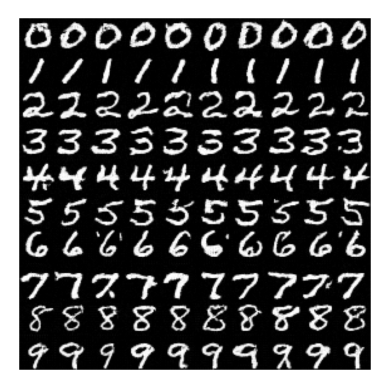

In [10]:
# ==================================================== #
# YOUR CODE HERE:
#   Among all images generated in the experiment,
#   show the image that you believe has the best generation quality.
#   You may use tools like matplotlib, PIL, OpenCV, ...

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your best image
# image_path = '/content/drive/MyDrive/Lab 2 - DDPM/save/your_exp_name/best_checkpoint.pth'  # Update the filename as needed
image_path = 'save/your_exp_name/images/generate_epoch_9.png'
# Load and display the image
# img = Image.open(image_path)
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()



# ==================================================== #

##### 2.5 Exploring the conditional guidance weight (3 points)

The generated images from the previous training-sampling process is using the default conditional guidance weight $\omega=2$. Now with the best checkpoint, please try at least 3 different $\omega$ values and visualize the generated images. You can use the provided function `sample_images` to get a combined image each time.

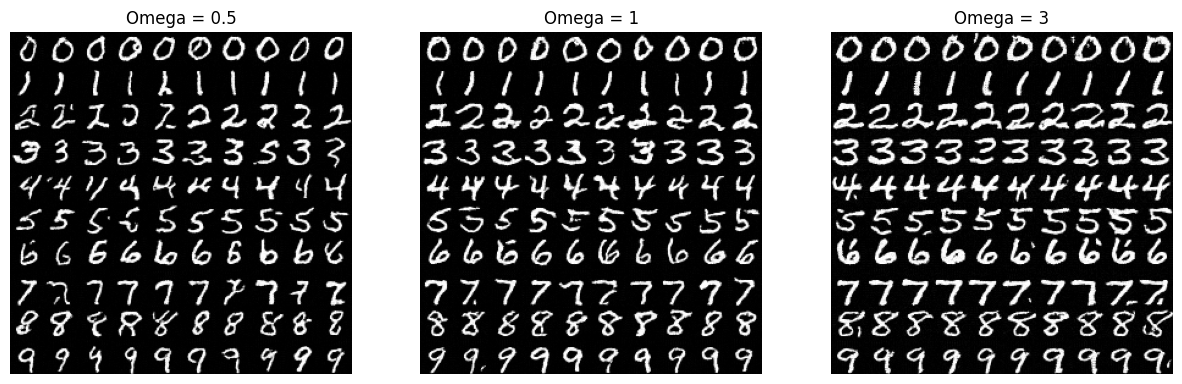

In [25]:
# from utils import sample_images
# import matplotlib.pyplot as plt
# ==================================================== #
# YOUR CODE HERE:
#   Try at least 3 different conditional guidance weights and visualize it.
#   Example of using a different omega value:
#       sample_config = DMConfig(omega = ?)
#       fig = sample_images(config = sample_config, checkpoint_path = path_to_your_checkpoint)
from utils import sample_images, DMConfig
import matplotlib.pyplot as plt

# Path to the best model checkpoint
checkpoint_path = 'save/your_exp_name/best_checkpoint.pth'

# List of omega values to try
omega_values = [0.5, 1, 3]

# Create a subplot
fig, axs = plt.subplots(1, len(omega_values), figsize=(15, 5))

# Iterate through each omega value, generate an image, and plot it
for i, omega in enumerate(omega_values):
    # Update the DMConfig with the new omega value
    sample_config = DMConfig(omega=omega)

    # Generate images with the updated configuration
    image = sample_images(config=sample_config, checkpoint_path=checkpoint_path)

    # Plotting
    axs[i].imshow(image)
    axs[i].set_title(f'Omega = {omega}')
    axs[i].axis('off')  # Hide axes

# Display all the plots
plt.show()

# ==================================================== #

**Inline Question: Based on your experiment, discuss how the conditional guidance weight affects the quality and diversity of generation.**

As omega is increased, we can clearly see that there is much less diversity in generation. The digits in each row for w = 3 look extremely similar to one another (precise straight lines, exact edges/curves, etc.) whereas the digits in each row for w = 0.5 are very different from one another. It seems as if a higher weight guidance helps to improve the quality of generation.


##### 2.6 Customize your own model (5 points)

Now let's experiment by modifying some hyperparameters in the config and costomizing your own model. You should at least change one defalut setting in the config and train a new model. Then visualize the generation image and discuss the effects of your modifications.

**Hint: Possible changes to the configuration include, but are not limited to,  the number of diffusion steps $T$, the unconditional condition drop ratio $mask\_p$, the feature size $num\_feat$, the beta schedule, etc.**

First you should define and print your modified config. Please state all the changes you made to the DMConfig class, i.e. `DMConfig(T=?, num_feat=?, ...)`.

In [35]:
# from dataclasses import dataclass, field
# from typing import List, Tuple
# class DMConfig:
#     '''
#     Define the model and experiment settings here
#     '''
#     input_dim: Tuple[int, int] = (28, 28) # input image size
#     num_channels: int = 1                 # input image channels
#     condition_mask_value: int = -1        # unconditional condition mask value
#     num_classes: int = 10                 # number of classes in the dataset
#     T: int = 400                          # diffusion and denoising steps
#     beta_1: float = 1e-4                  # variance schedule
#     beta_T: float = 2e-2
#     mask_p: float = 0.1                   # unconditional condition drop ratio
#     num_feat: int = 128                   # feature size of the UNet model
#     omega: float = 2.0                    # conditional guidance weight

#     batch_size: int = 256                 # training batch size
#     epochs: int = 10                      # training epochs
#     learning_rate: float = 1e-4           # training learning rate
#     multi_lr_milestones: List[int] = field(default_factory=lambda: [20]) # learning rate decay milestone
#     multi_lr_gamma: float = 0.1           # learning rate decay ratio

# ==================================================== #
# YOUR CODE HERE:
#   Your new configuration:
#   train_config_new = DMConfig(...)
train_config_new = DMConfig(T=200, learning_rate = .0002, epochs =10)

# ==================================================== #
print(train_config_new)

DMConfig(input_dim=(28, 28), num_channels=1, condition_mask_value=-1, num_classes=10, T=200, omega=2.0, batch_size=256, epochs=10, learning_rate=0.0002, multi_lr_milestones=[20], multi_lr_gamma=0.1)


Then similar to 2.4, use `solver` funtion to complete the training and sampling process.

In [36]:
from utils import solver
solver(dmconfig = train_config_new,
       exp_name = 'your_exp_name_new',
       train_loader = train_loader,
       test_loader = test_loader)

epoch 1/10


train: train_noise_loss = 0.2722 test: test_noise_loss = 0.1413
epoch 2/10


train: train_noise_loss = 0.1290 test: test_noise_loss = 0.1148
epoch 3/10


train: train_noise_loss = 0.1098 test: test_noise_loss = 0.1038
epoch 4/10


train: train_noise_loss = 0.0997 test: test_noise_loss = 0.0980
epoch 5/10


train: train_noise_loss = 0.0915 test: test_noise_loss = 0.0936
epoch 6/10


train: train_noise_loss = 0.0869 test: test_noise_loss = 0.0848
epoch 7/10


train: train_noise_loss = 0.0831 test: test_noise_loss = 0.0839
epoch 8/10


train: train_noise_loss = 0.0805 test: test_noise_loss = 0.0797
epoch 9/10


train: train_noise_loss = 0.0780 test: test_noise_loss = 0.0778
epoch 10/10


train: train_noise_loss = 0.0757 test: test_noise_loss = 0.0747


Finally, show one image that you think has the best quality.

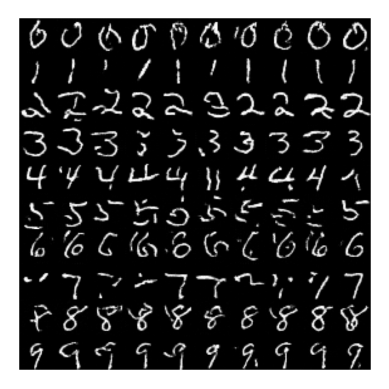

In [37]:
# ==================================================== #
# YOUR CODE HERE:
#   Among all images generated in the experiment,
#   show the image that you believe has the best generation quality.
#   You may use tools like matplotlib, PIL, OpenCV, ...
image_path_new = 'save/your_exp_name_new/images/generate_epoch_9.png'
# Load and display the image
# img = Image.open(image_path)
img = mpimg.imread(image_path_new)
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


# ==================================================== #

**Inline Question: Discuss the effects of your modifications after you compare the generation performance under different configurations.**

I modified the number of diffusion steps from 400 to 200 and the learning rate from .0001 to .0002. It is clear that this modification decreased the quality and precision of the generation immensely.

#### Why decreasing the number of diffusion steps might have led to worse output
The reason why decreasing the number of diffusion steps might lead to less cohesiveness amongst number generation is because DDPMs are structured to gradually denoise a data distribution over a series of steps, starting from a pure noise distribution and progressively denoising it to resemble the data distribution. This process mimics a Markov chain, where each step slightly denoises the sample. With fewer steps, the model has less capacity to make these gradual adjustments, and as a result, the denoising process may not sufficiently bridge the gap between the noise distribution and the target data distribution. More diffusion steps allow the model to learn a series of simpler transformations at each step, rather than a few complex transformations. This gradual transformation helps in stabilizing the training process and allows the model to capture finer details of the data distribution. Fewer steps require the model to perform larger denoising jumps at each step, which can be harder to learn and result in generated samples that are less detailed or exhibit artifacts.  In each diffusion step, a small amount of noise is added, and information about the original data is slightly lost but is meant to be recoverable. With fewer steps, the amount of noise added at each step might need to be larger to ensure the process ends in a fully noisy state by the last step. This can make the recovery process (reverse diffusion) less precise as more critical information may be lost in fewer, noisier steps.

#### Why increasing the learning rate may have led to less desired output

If the learning rate is too high, the updates may become too large, causing the model to oscillate around or even diverge from the optimal points in the loss landscape. This can result in an unstable training process, where the loss fails to decrease in a consistent manner which results in poor generalization. The model may end up in regions of the parameter space that are not as robust, missing finer details that a slower learning process might capture. For generative models like DDPMs, this means the generated samples might be of lower quality, exhibiting artifacts or not capturing the diversity of the true data distribution.